In [158]:
# Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

import copy
import numpy as np
import os
import seaborn as sns
import pandas as pd
import datetime as dt
from sklearn_pandas import DataFrameMapper

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from zlib import crc32
import hashlib
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from six.moves import urllib
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
StratifiedKFold, GroupShuffleSplit,
GroupKFold, StratifiedShuffleSplit,cross_val_score)
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (MinMaxScaler, StandardScaler, PolynomialFeatures,OrdinalEncoder,OneHotEncoder)
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta import add_all_ta_features
import numpy as np
import pandas as pd
from sklearn.ensemble import *
import xgboost as xgb
import operator

import settings
from ta import *
import utils
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.metrics import mean_absolute_error

import datetime, pytz
from torch.optim.lr_scheduler import ReduceLROnPlateau

#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

# Donde guardar las figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Model definition
- ARIMA
- LTSM

In [159]:
EPSILON = 0.0001
def training_loop(n_epochs, lstm, optimizer, loss_fn, X_train, y_train,
                  X_test, y_test):
    training_history = []
    last_loss = -1.0
    last_test_loss = -1
    # lstm.to("cuda")
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimizer.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimizer.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        
        # scheduler.step(test_loss)
        
        if epoch % 10 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item()))
            
            train_predict = lstm.forward(X_test) # forward pass
            data_predict = train_predict.data.numpy() # numpy conversion
            dataY_plot = y_test.data.numpy()

            true, preds = [], []
            for i in range(len(dataY_plot)):
                true.append(dataY_plot[i][0])
            for i in range(len(data_predict)):
                preds.append(data_predict[i][0])
            plt.figure(figsize=(10,6)) #plotting
            # plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

            plt.plot(true, label='Actual Data') # actual plot
            plt.plot(preds, label='Predicted Data') # predicted plot
            plt.title('Time-Series Prediction')
            plt.legend()
            plt.savefig("whole_plot.png", dpi=300)
            plt.show() 
            
        # if abs(last_loss - loss.item()) < EPSILON and abs(test_loss - last_test_loss.item()) < EPSILON:
            # print("Stuck in training, stopping...")
            # break
            
        last_loss = loss
        last_test_loss = test_loss
        training_history.append((copy.deepcopy(lstm), loss.item(), test_loss.item()))

    return training_history

In [160]:
class LSTM(nn.Module):
    # tendriamos que ir probando iterativamente la cantidad de capas
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

# Find best hyperparameters
GridsearchCV

## Split train - test

In [161]:
bitcoin_hist = pd.read_csv("processed_data/processed_bitcoin_history.csv")
df = bitcoin_hist.drop('Timestamp',axis=1)
# df = df.drop('Date',axis=1)

In [162]:
# amount of nan in the dataset
df[bitcoin_hist.isna().any(axis=1)]

Close_previous     Close  Volume_BTC  Volume_USD  volume_adi  \
910005             NaN  3.297643   -0.209518    0.085316   -0.685188   

        volume_cmf  volume_fi  volume_vpt  volume_vwap  volatility_kcw  ...  \
910005    0.105018  -0.005897    0.008634     3.302876        -0.41089  ...   

        trend_adx  momentum_stoch_signal  others_dr  Target  Year  Month  \
910005   -0.62667              -1.109128  -0.481454       0  2021      3   

        Week  Weekday  Day  Hour  
910005    13        0   29    20  

[1 rows x 26 columns]

In [153]:
df = df[:-1] # esto es para sacar el NaN del final

In [163]:
df = df[:10000]
df

Close_previous     Close  Volume_BTC  Volume_USD  volume_adi  \
0          -0.312655 -0.312282   -0.298249   -0.325021    1.132035   
1          -0.312264 -0.312654   -0.297807   -0.324676    1.132034   
2          -0.311670 -0.312264   -0.304574   -0.329908    1.132035   
3          -0.311475 -0.311670   -0.305649   -0.330733    1.132036   
4          -0.311981 -0.311475   -0.145106   -0.206449    1.132050   
...              ...       ...         ...         ...         ...   
9995       -0.300094 -0.298732   -0.314487   -0.337556    1.140491   
9996       -0.298602 -0.300094   -0.255088   -0.290964    1.140486   
9997       -0.297907 -0.298602   -0.313417   -0.336713    1.140486   
9998       -0.297978 -0.297907   -0.271922   -0.304107    1.140490   
9999       -0.298845 -0.297978   -0.301751   -0.327541    1.140489   

      volume_cmf  volume_fi  volume_vpt  volume_vwap  volatility_kcw  ...  \
0      -0.198466  -0.134613   -0.297818    -0.312061       -0.429037  ...   
1      -0.202576  -0.113538    0.007376    -0.311960       -0.386142  ...   
2      -0.216212  -0.094743    0.007543    -0.311952       -0.427955  ...   
3      -0.221579  -0.078523    0.009071    -0.311955       -0.450460  ...   
4      -0.193773  -0.062877    0.012437    -0.311927       -0.440856  ...   
...          ...        ...         ...          ...             ...  ...   
9995    0.194276   0.143086    0.001476    -0.299986        0.381011  ...   
9996    0.188366   0.119570   -0.001628    -0.299578        0.279461  ...   
9997    0.183285   0.105033   -0.001313    -0.299556       -0.030282  ...   
9998    0.184942   0.094294    0.011826    -0.299518       -0.123645  ...   
9999    0.180873   0.083042    0.011241    -0.299411       -0.256462  ...   

      trend_adx  momentum_stoch_signal  others_dr  Target  Year  Month  Week  \
0      0.112601               0.009101   0.159990       0  2019      7    27   
1      0.104048              -0.480458  -0.351713       0  2019      7    27   
2      0.096107              -0.772073   0.364492       0  2019      7    27   
3      0.020100              -0.907051   0.555561       0  2019      7    27   
4     -0.071988              -0.703087   0.180268       0  2019      7    27   
...         ...                    ...        ...     ...   ...    ...   ...   
9995  -0.312432               0.825888   0.737444       0  2019      7    28   
9996  -0.332678               0.695353  -1.260585       0  2019      7    28   
9997  -0.295104               0.801595   1.378574       0  2019      7    28   
9998  -0.233435               0.898089   0.640370       0  2019      7    28   
9999  -0.162019               1.161509  -0.068145       0  2019      7    28   

      Weekday  Day  Hour  
0           5    6    22  
1           5    6    22  
2           5    6    22  
3           5    6    22  
4           5    6    22  
...       ...  ...   ...  
9995        5   13    20  
9996        5   13    20  
9997        5   13    20  
9998        5   13    20  
9999        5   13    20  

[10000 rows x 26 columns]

In [164]:
last_items = int(df.Close.count()*0.2)
X = df.head(df.Close.count()-last_items)
y = df.tail(last_items)

In [165]:
n_epochs = 1000 # 1000 epochs
learning_rate = 5.0 # 0.001 lr

input_size = 25 # number of features
hidden_size = 13 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 1 # number of output classes 

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

TRAIN: [   0    1    2 ... 2665 2666 2667] TEST: [2668 2669 2670 ... 5331 5332 5333]
Epoch: 0, train loss: 0.07339, test loss: 819863.93750


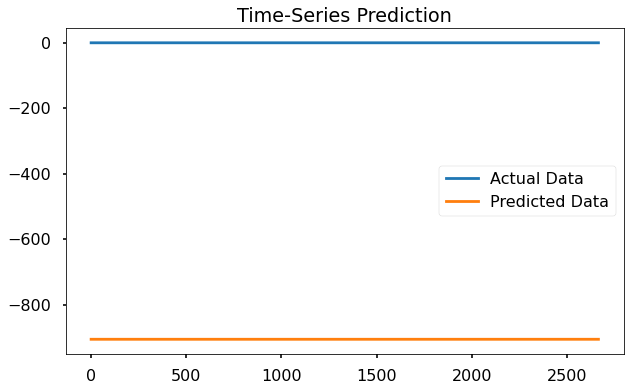

Epoch: 10, train loss: 112.94196, test loss: 124.50977


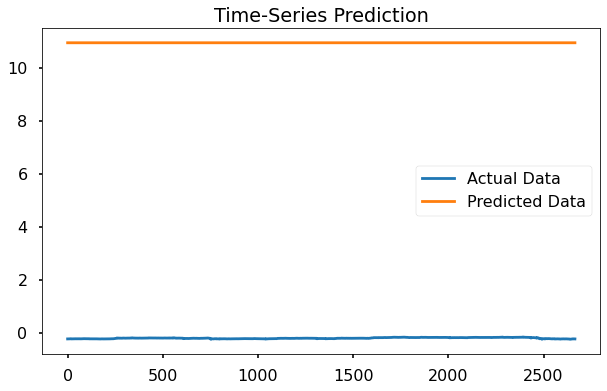

Epoch: 20, train loss: 183.16133, test loss: 180.58804


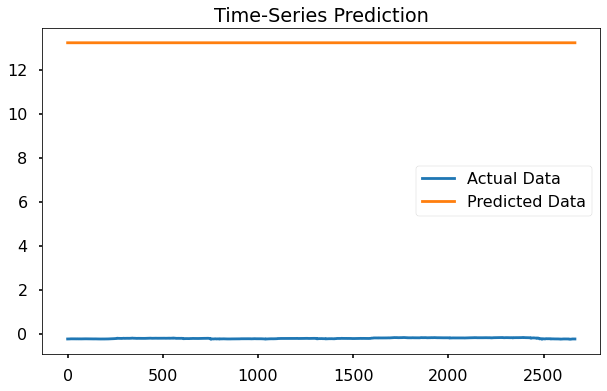

Epoch: 30, train loss: 145.94186, test loss: 137.47728


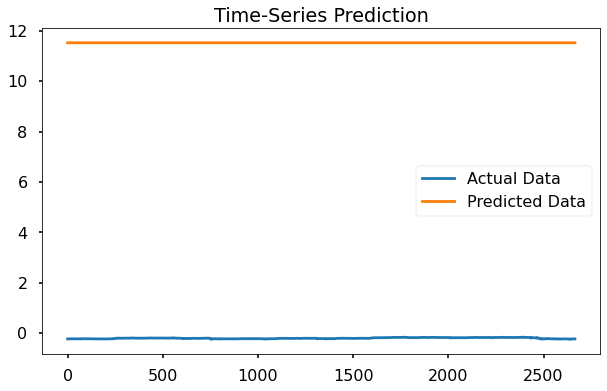

Epoch: 40, train loss: 80.16441, test loss: 72.67970


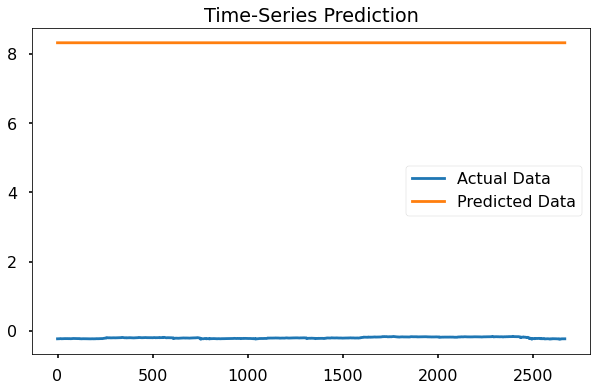

Epoch: 50, train loss: 31.73302, test loss: 27.44369


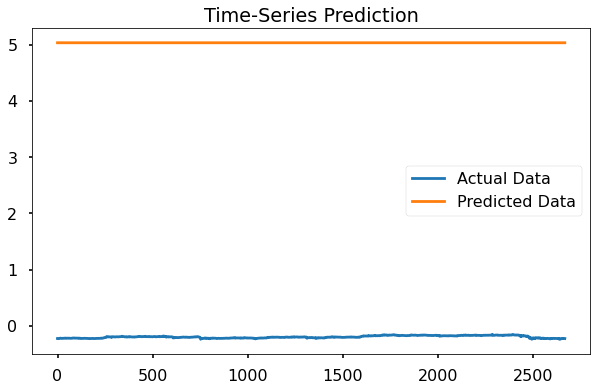

Epoch: 60, train loss: 8.46145, test loss: 6.74178


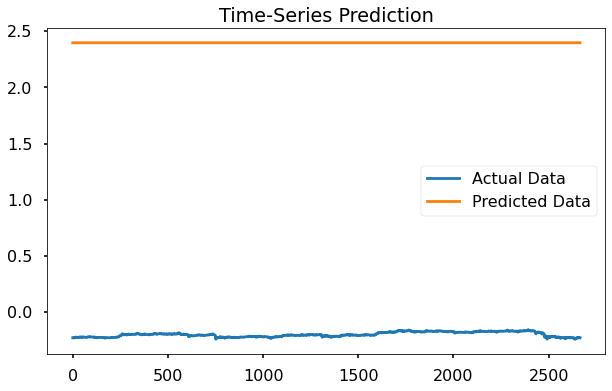

Epoch: 70, train loss: 1.13767, test loss: 0.71214


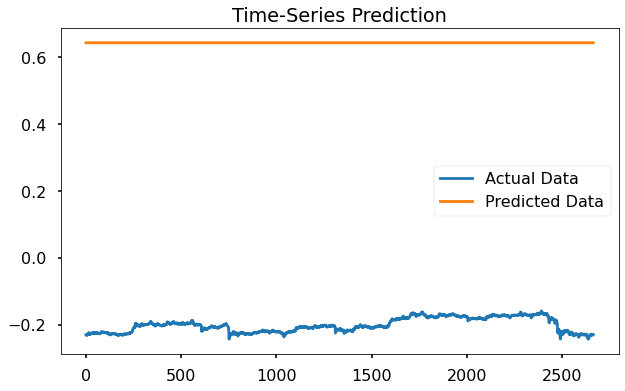

Epoch: 80, train loss: 0.00392, test loss: 0.00881


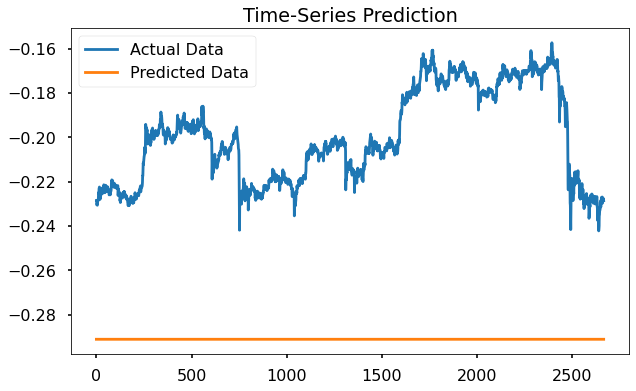

Epoch: 90, train loss: 0.11166, test loss: 0.19042


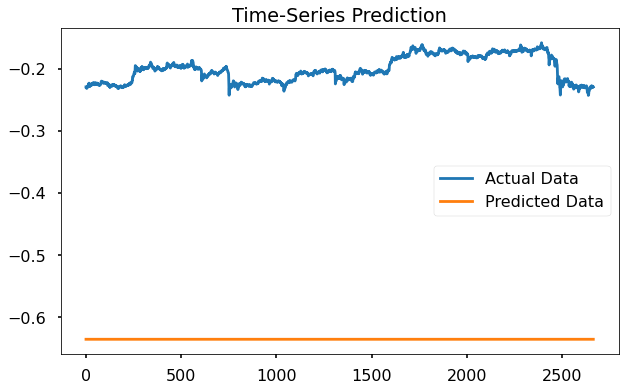

Epoch: 100, train loss: 0.13351, test loss: 0.19749


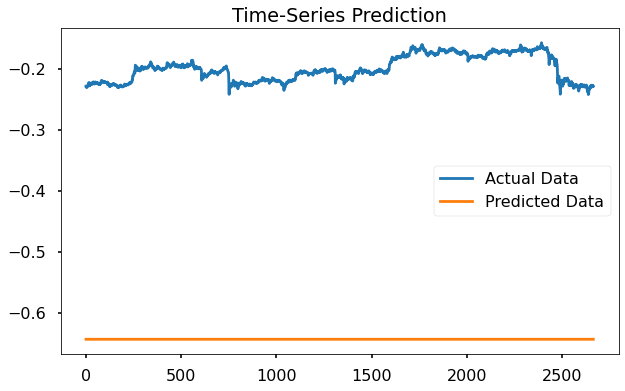

Epoch: 110, train loss: 0.06130, test loss: 0.10251


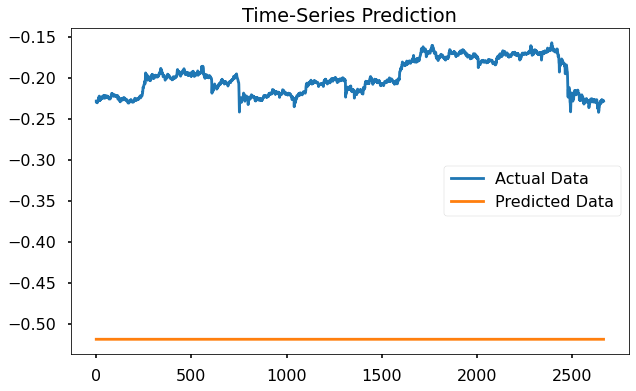

Epoch: 120, train loss: 0.01303, test loss: 0.03557


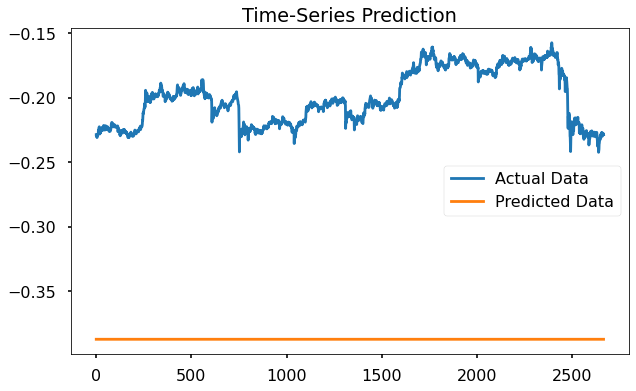

Epoch: 130, train loss: 0.00091, test loss: 0.01054


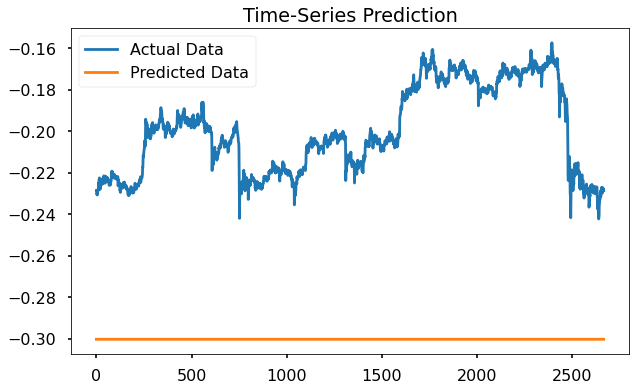

Epoch: 140, train loss: 0.00099, test loss: 0.00450


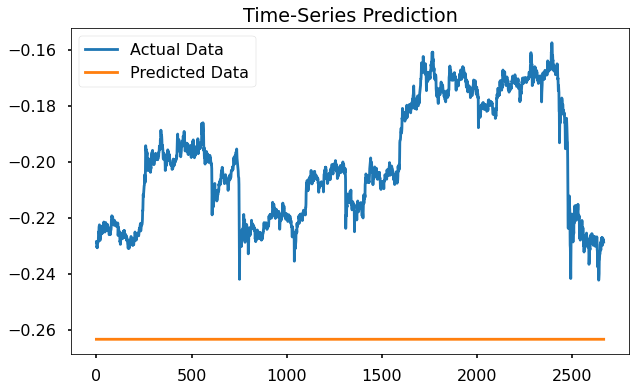

Epoch: 150, train loss: 0.00127, test loss: 0.00407


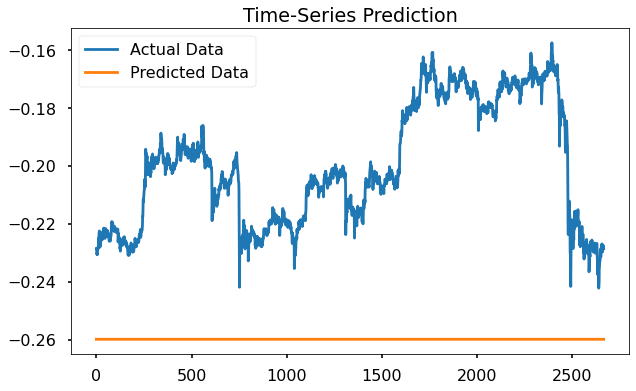

Epoch: 160, train loss: 0.00083, test loss: 0.00543


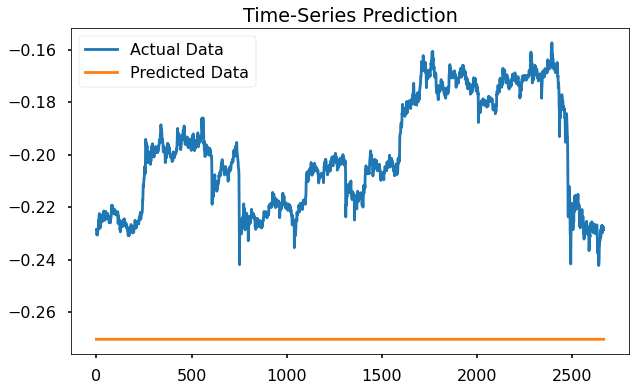

Epoch: 170, train loss: 0.00056, test loss: 0.00713


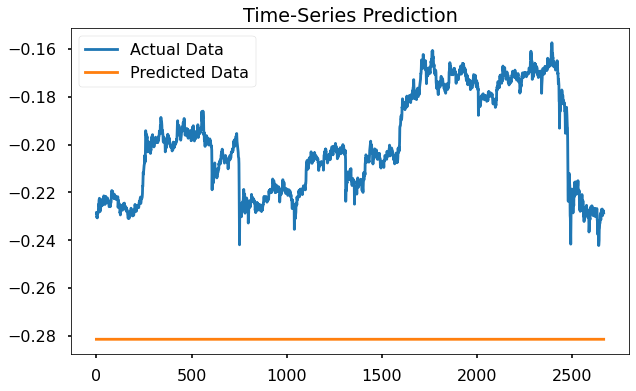

Epoch: 180, train loss: 0.00052, test loss: 0.00823


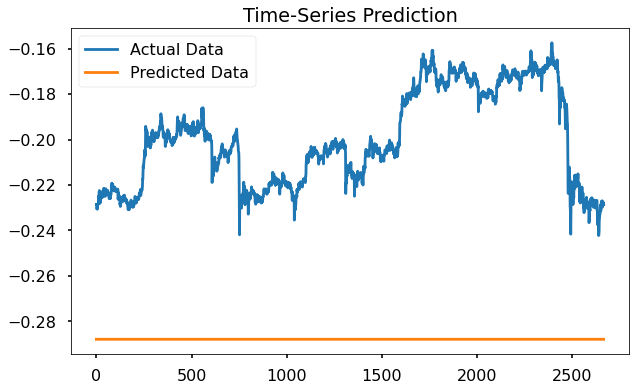

Epoch: 190, train loss: 0.00053, test loss: 0.00855


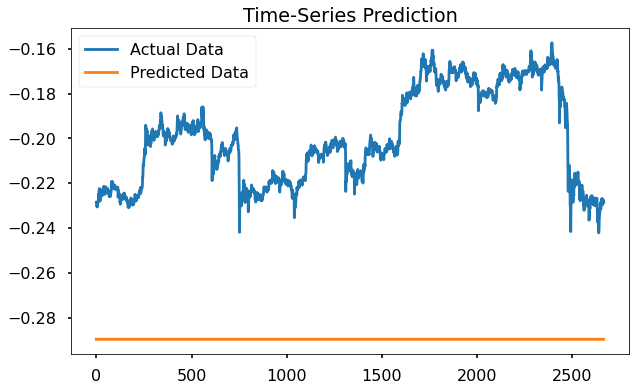

Epoch: 200, train loss: 0.00052, test loss: 0.00841


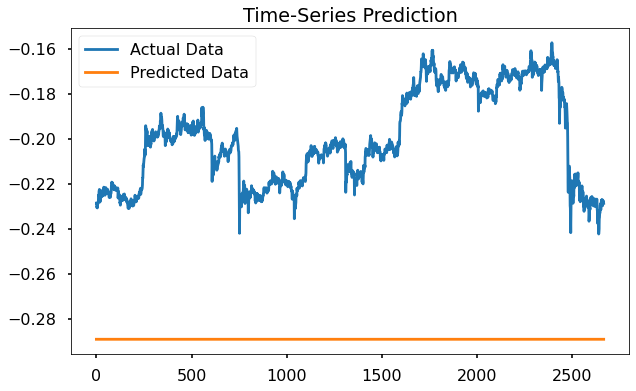

Epoch: 210, train loss: 0.00052, test loss: 0.00817


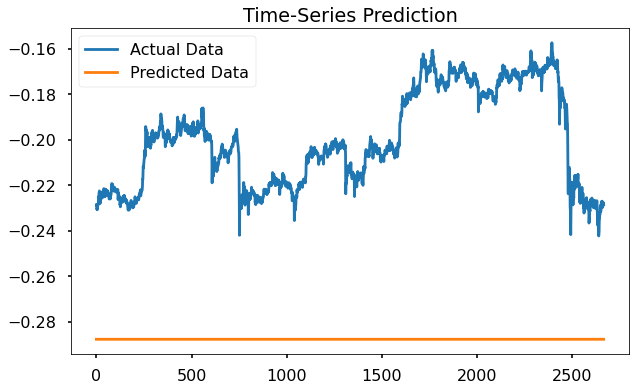

Epoch: 220, train loss: 0.00052, test loss: 0.00802


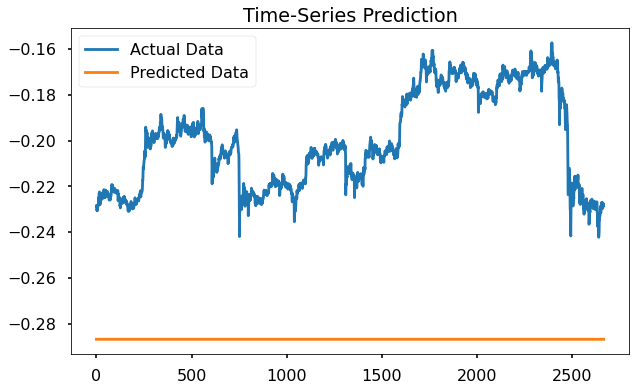

Epoch: 230, train loss: 0.00052, test loss: 0.00797


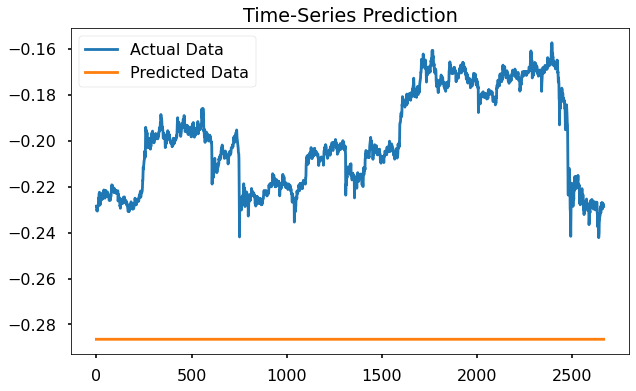

Epoch: 240, train loss: 0.00052, test loss: 0.00799


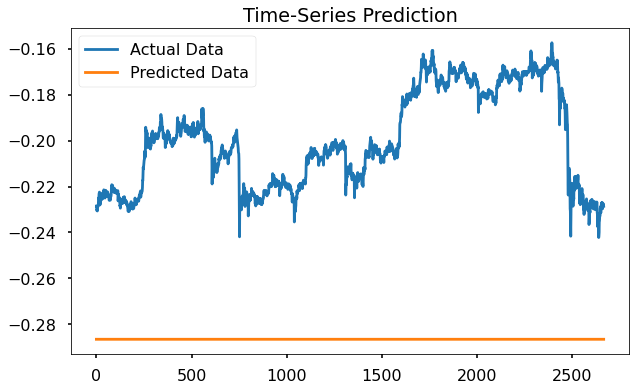

Epoch: 250, train loss: 0.00052, test loss: 0.00802


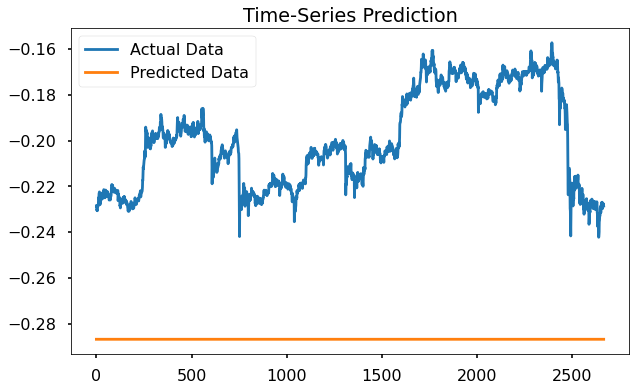

Epoch: 260, train loss: 0.00052, test loss: 0.00804


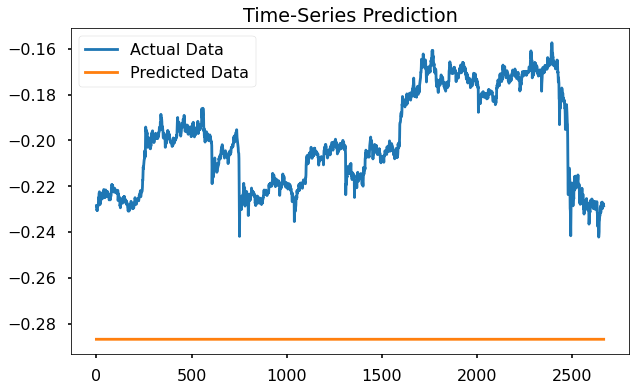

Epoch: 270, train loss: 0.00052, test loss: 0.00805


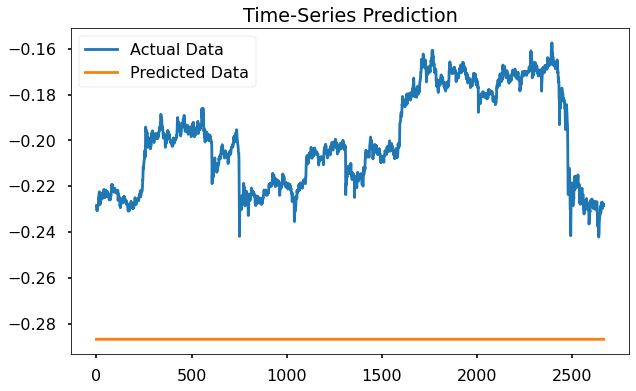

Epoch: 280, train loss: 0.00052, test loss: 0.00804


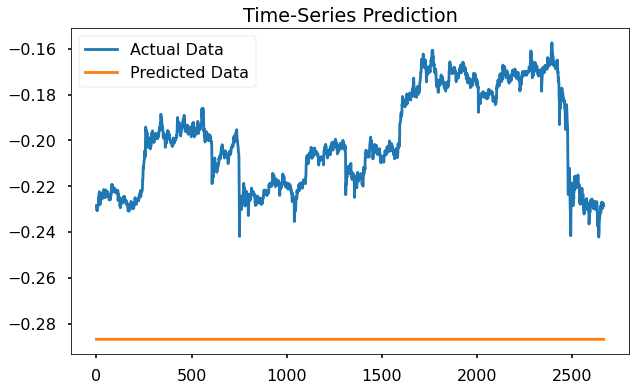

Epoch: 290, train loss: 0.00052, test loss: 0.00804


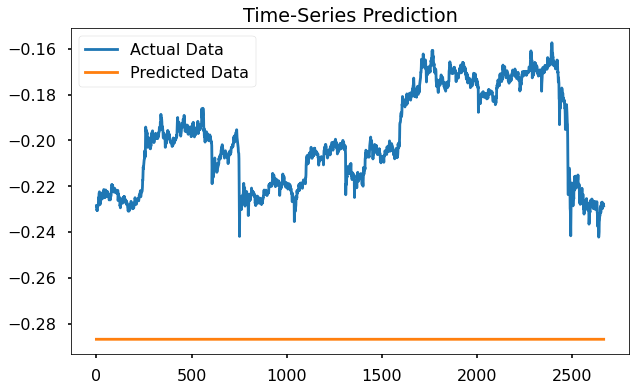

Epoch: 300, train loss: 0.00052, test loss: 0.00804


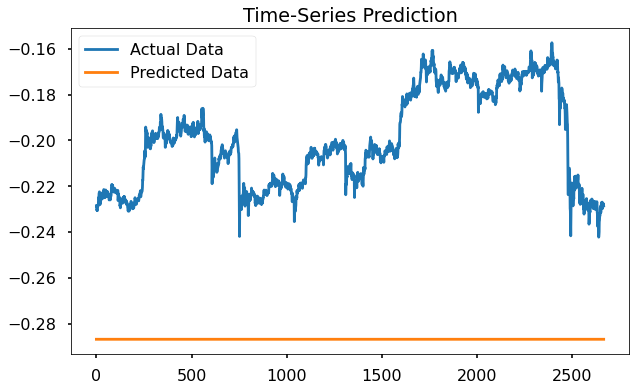

Epoch: 310, train loss: 0.00052, test loss: 0.00804


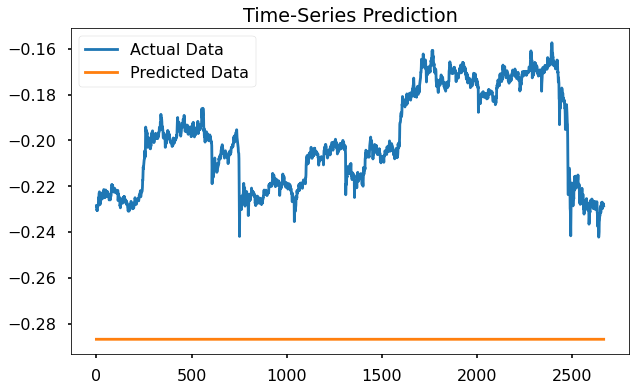

Epoch: 320, train loss: 0.00052, test loss: 0.00804


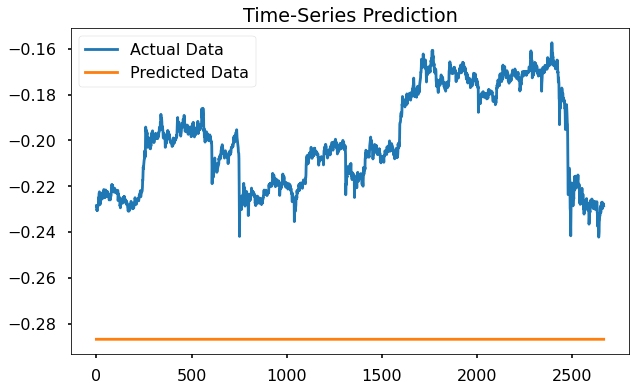

Epoch: 330, train loss: 0.00052, test loss: 0.00804


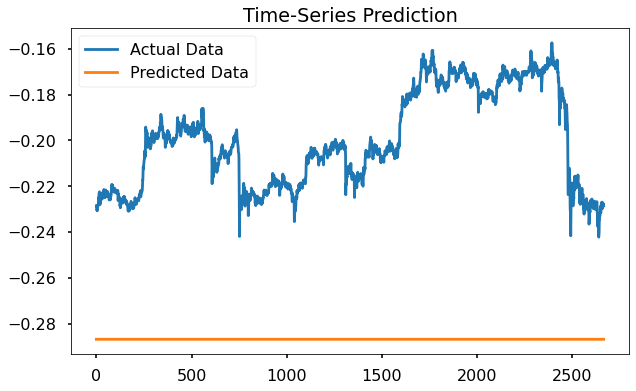

Epoch: 340, train loss: 0.00052, test loss: 0.00804


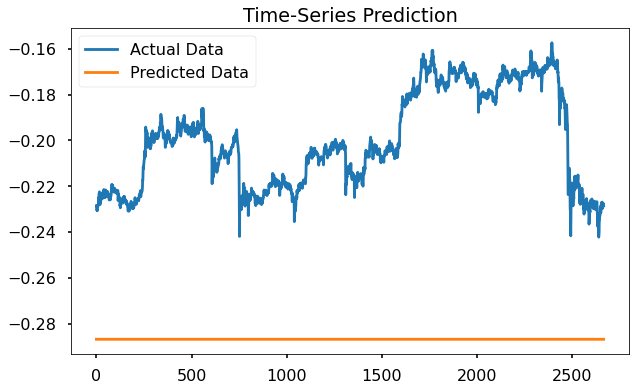

Epoch: 350, train loss: 0.00052, test loss: 0.00804


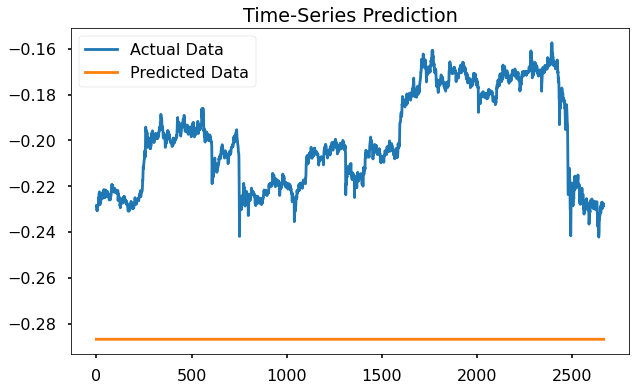

Epoch: 360, train loss: 0.00052, test loss: 0.00804


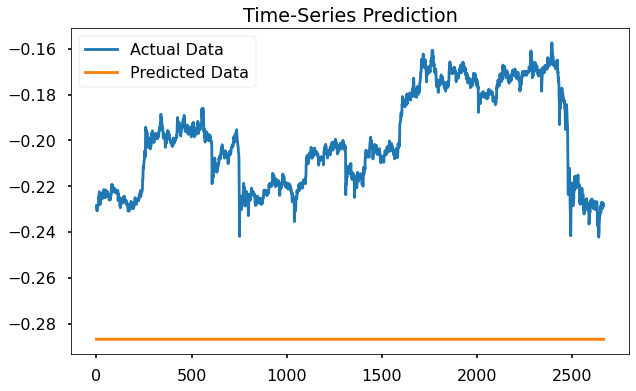

Epoch: 370, train loss: 0.00052, test loss: 0.00804


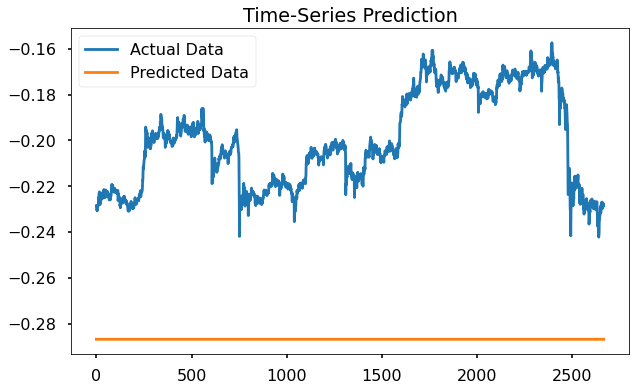

Epoch: 380, train loss: 0.00052, test loss: 0.00804


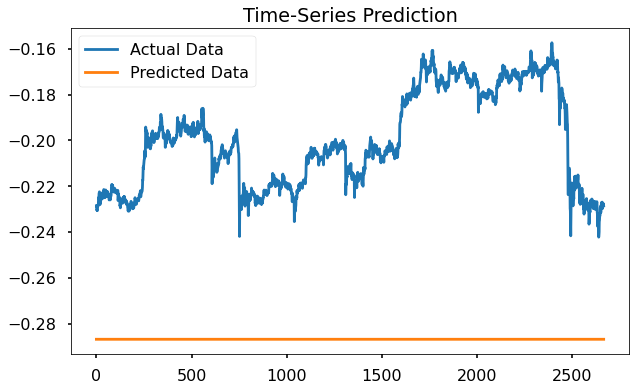

Epoch: 390, train loss: 0.00052, test loss: 0.00804


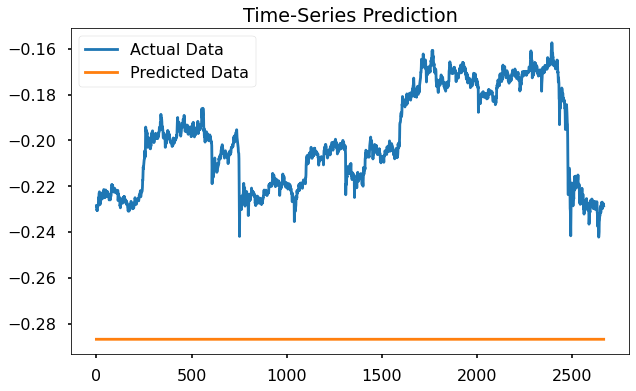

Epoch: 400, train loss: 0.00052, test loss: 0.00804


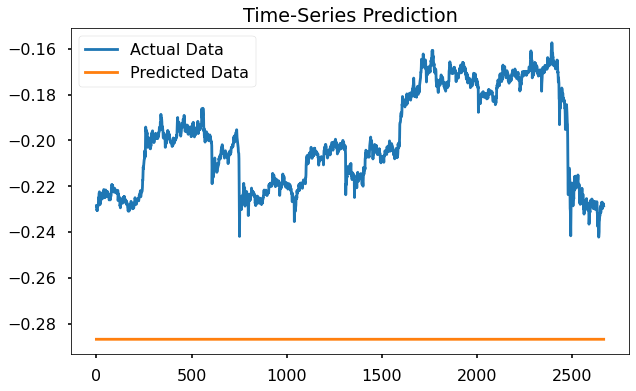

Epoch: 410, train loss: 0.00052, test loss: 0.00804


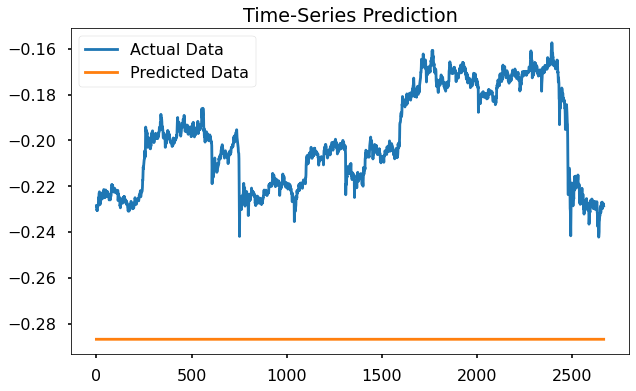

Epoch: 420, train loss: 0.00052, test loss: 0.00804


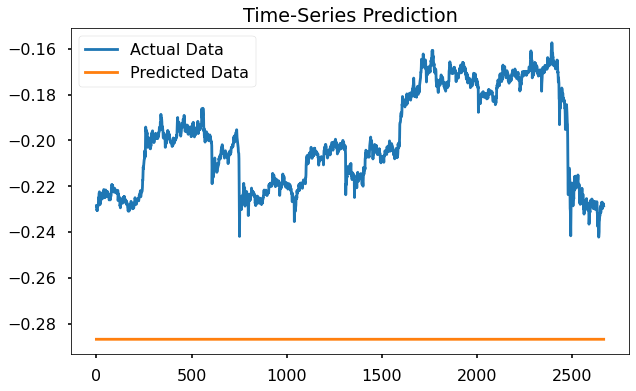

Epoch: 430, train loss: 0.00052, test loss: 0.00804


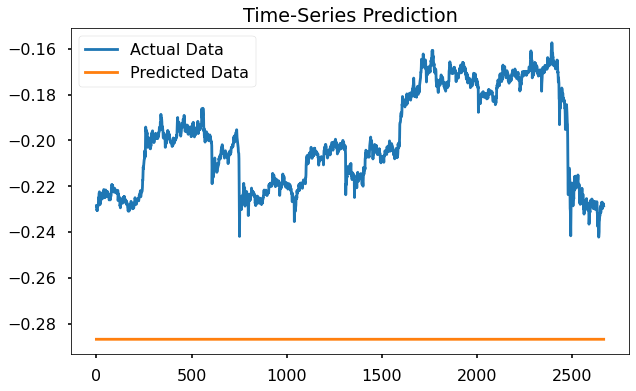

Epoch: 440, train loss: 0.00052, test loss: 0.00804


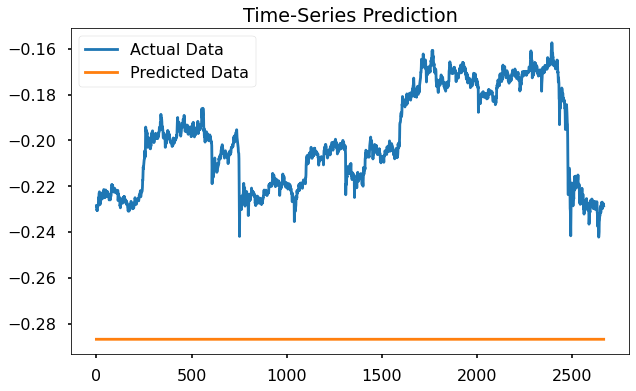

Epoch: 450, train loss: 0.00052, test loss: 0.00804


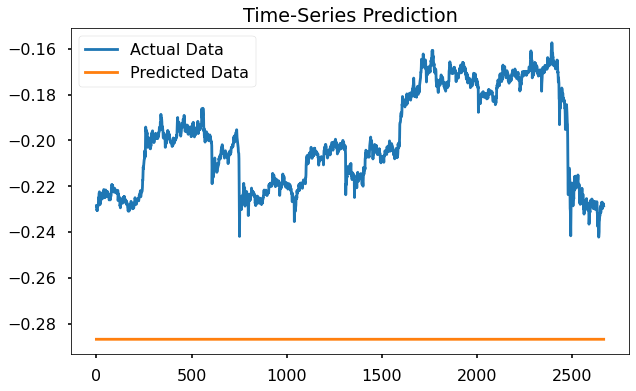

Epoch: 460, train loss: 0.00052, test loss: 0.00804


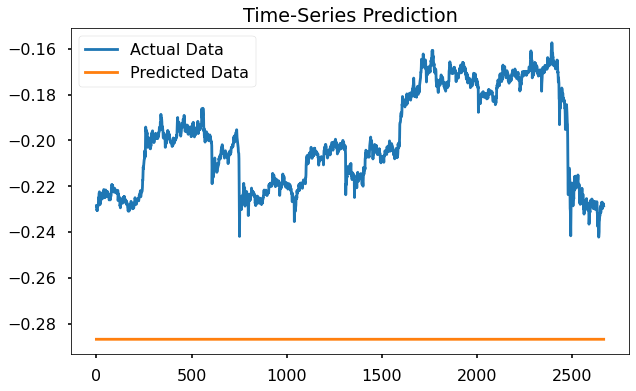

Epoch: 470, train loss: 0.00052, test loss: 0.00804


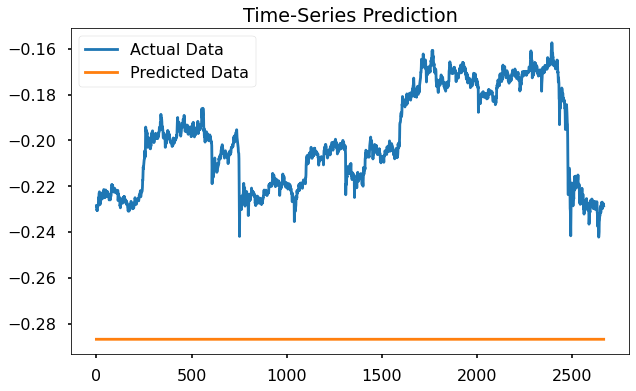

Epoch: 480, train loss: 0.00052, test loss: 0.00804


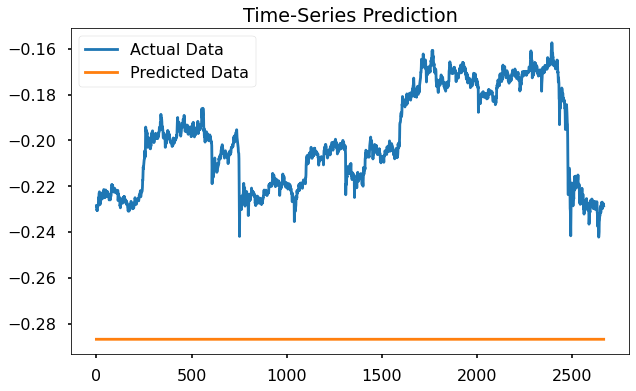

Epoch: 490, train loss: 0.00052, test loss: 0.00804


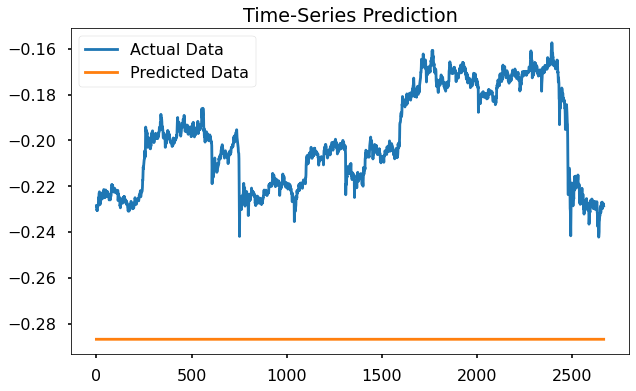

Epoch: 500, train loss: 0.00052, test loss: 0.00804


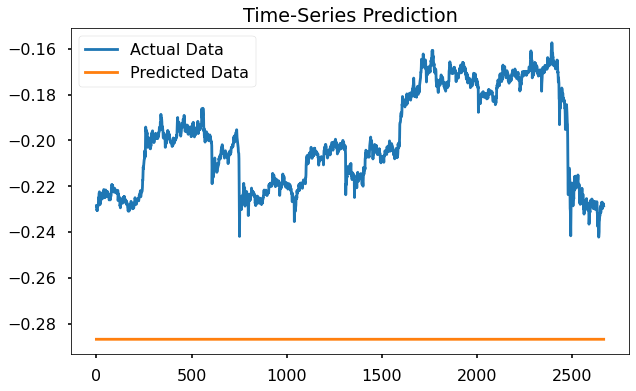

Epoch: 510, train loss: 0.00052, test loss: 0.00804


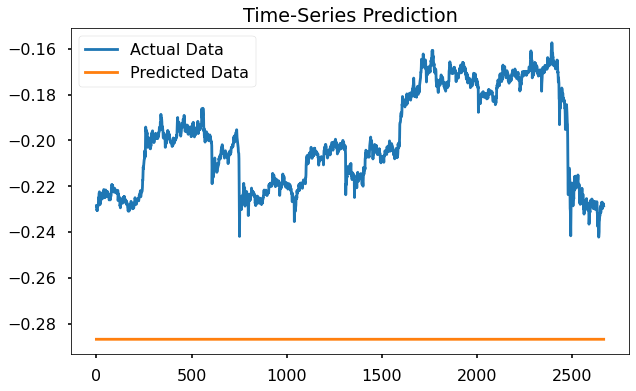

Epoch: 520, train loss: 0.00052, test loss: 0.00804


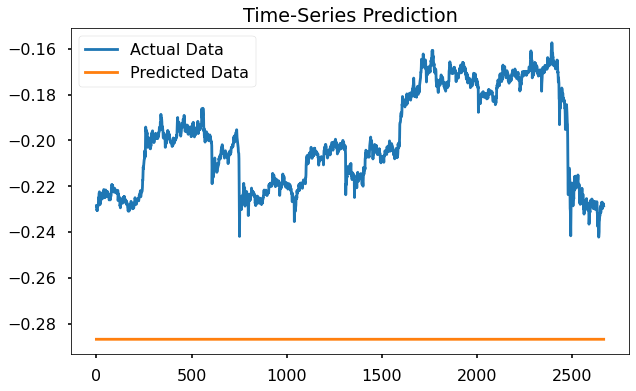

Epoch: 530, train loss: 0.00052, test loss: 0.00804


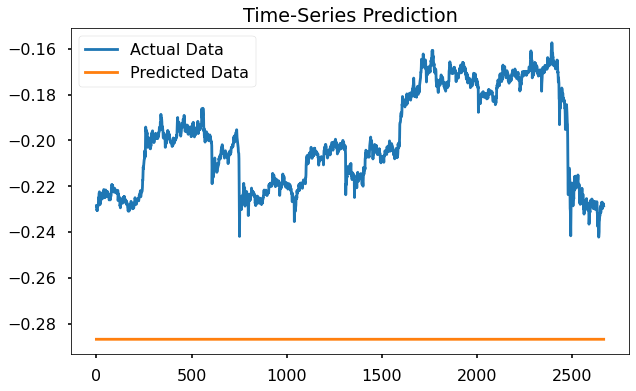

Epoch: 540, train loss: 0.00052, test loss: 0.00804


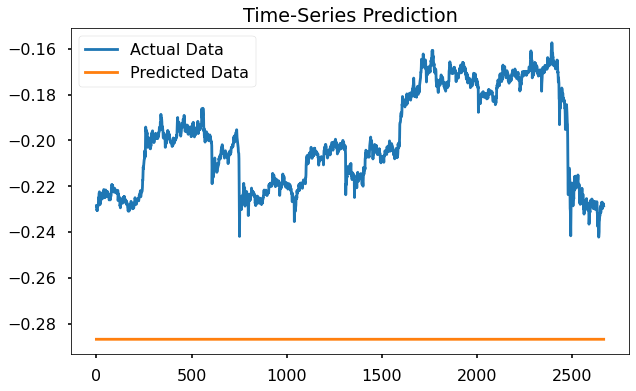

Epoch: 550, train loss: 0.00052, test loss: 0.00804


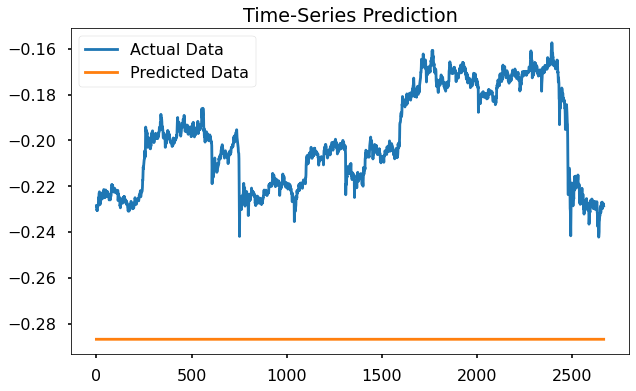

Epoch: 560, train loss: 0.00052, test loss: 0.00804


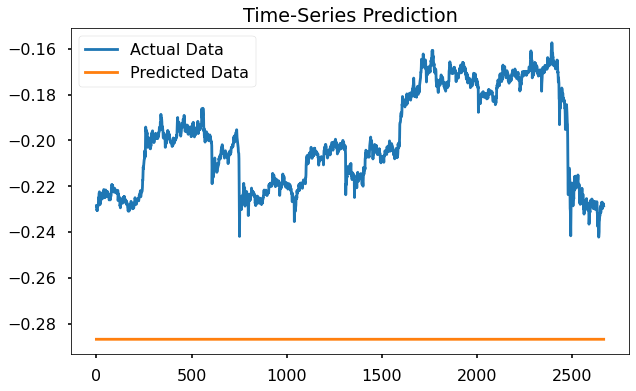

Epoch: 570, train loss: 0.00052, test loss: 0.00804


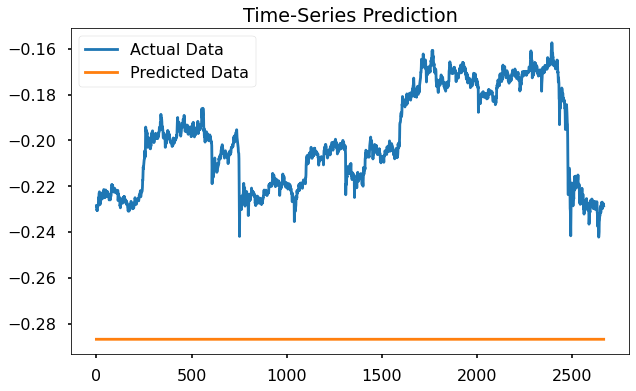

Epoch: 580, train loss: 0.00052, test loss: 0.00804


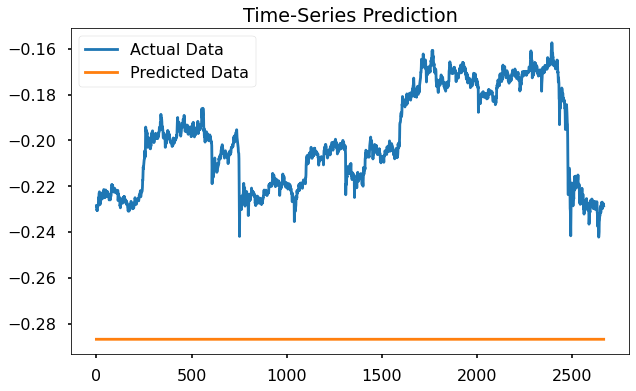

Epoch: 590, train loss: 0.00052, test loss: 0.00804


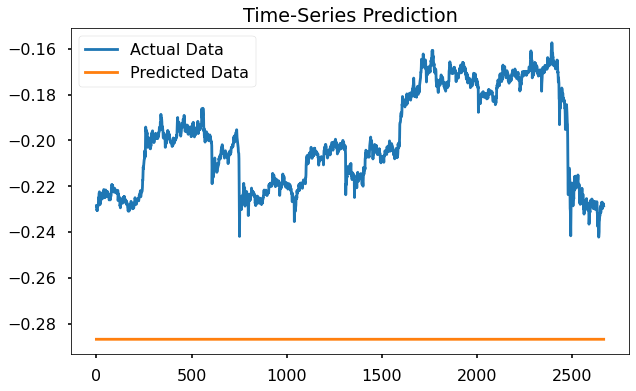

Epoch: 600, train loss: 0.00052, test loss: 0.00804


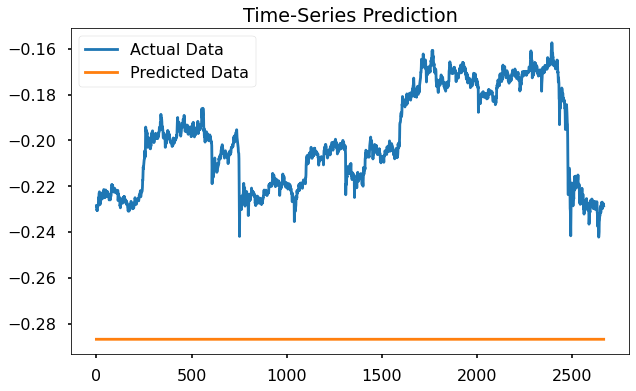

Epoch: 610, train loss: 0.00052, test loss: 0.00804


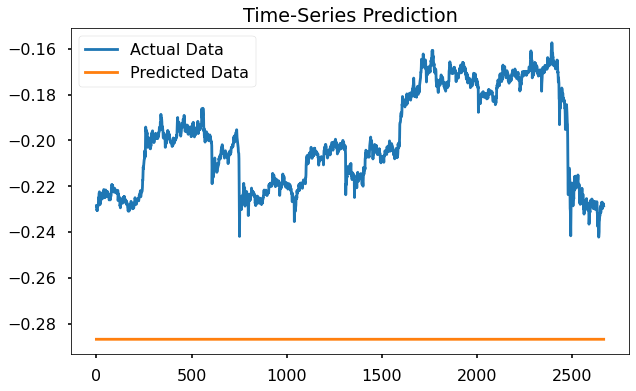

Epoch: 620, train loss: 0.00052, test loss: 0.00804


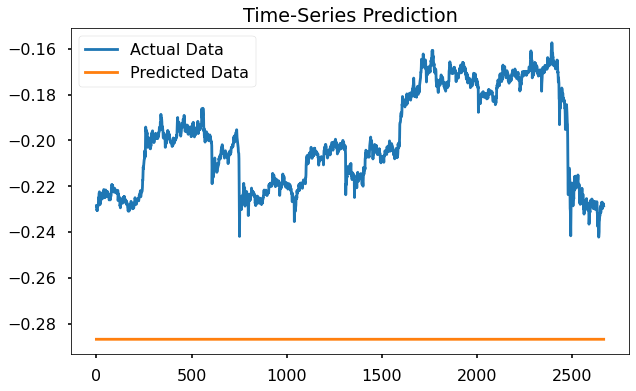

Epoch: 630, train loss: 0.00052, test loss: 0.00804


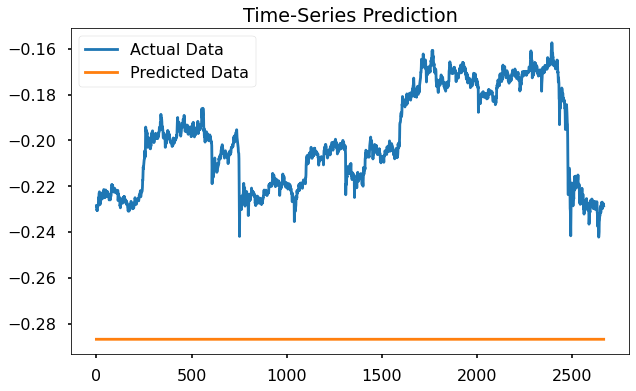

Epoch: 640, train loss: 0.00052, test loss: 0.00804


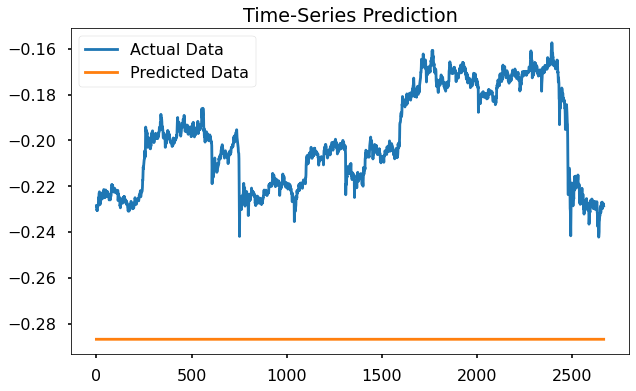

Epoch: 650, train loss: 0.00052, test loss: 0.00804


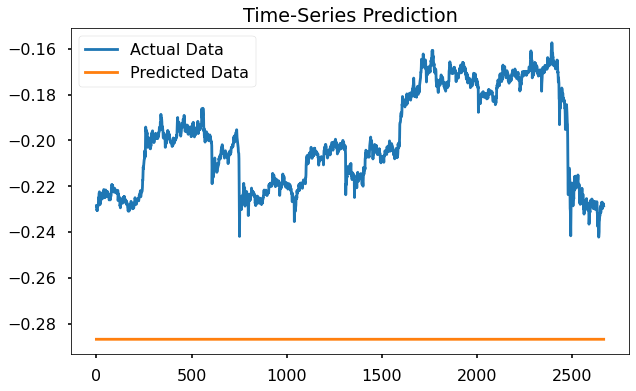

Epoch: 660, train loss: 0.00052, test loss: 0.00804


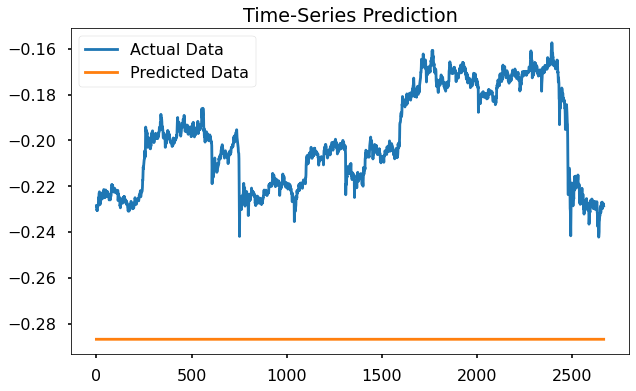

Epoch: 670, train loss: 0.00052, test loss: 0.00804


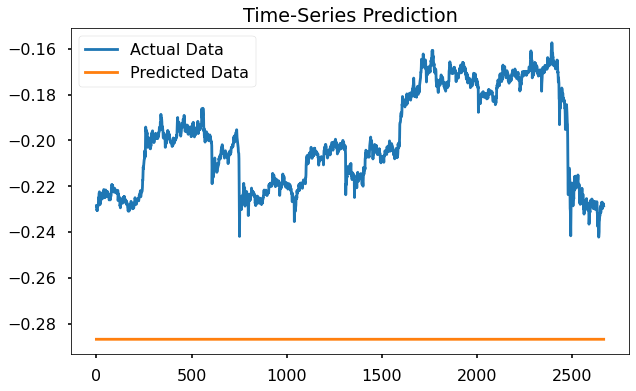

Epoch: 680, train loss: 0.00052, test loss: 0.00804


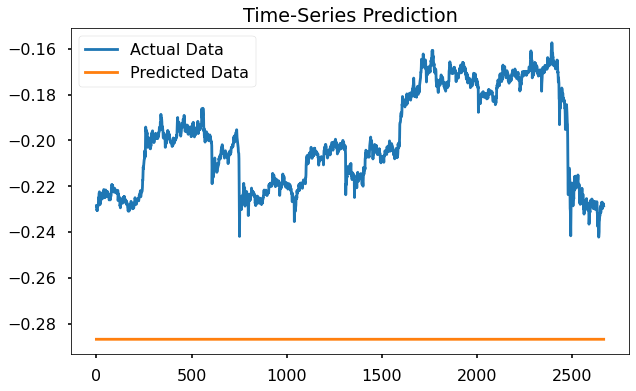

Epoch: 690, train loss: 0.00052, test loss: 0.00804


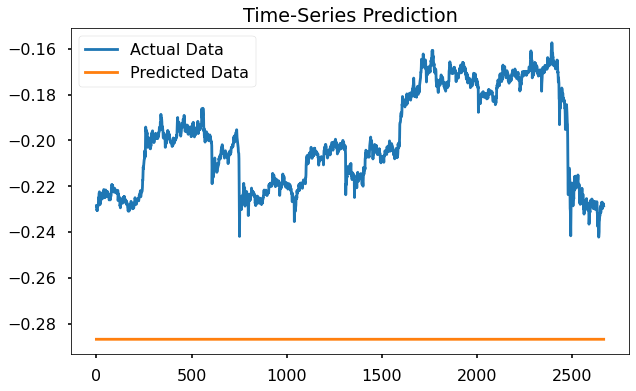

Epoch: 700, train loss: 0.00052, test loss: 0.00804


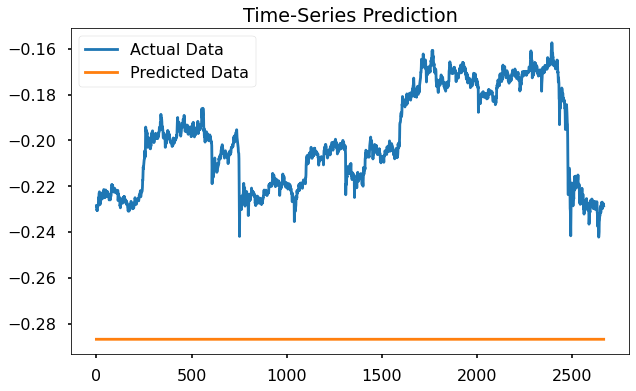

Epoch: 710, train loss: 0.00052, test loss: 0.00804


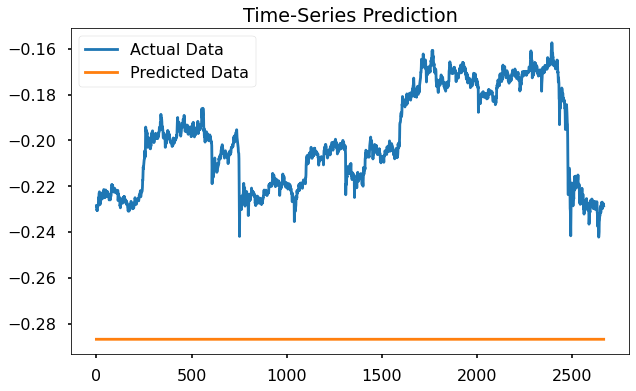

Epoch: 720, train loss: 0.00052, test loss: 0.00804


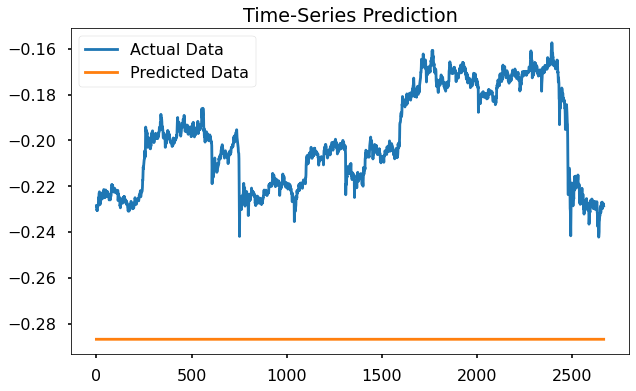

Epoch: 730, train loss: 0.00052, test loss: 0.00804


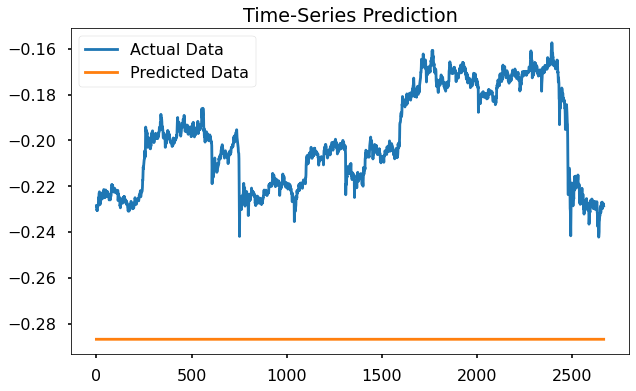

Epoch: 740, train loss: 0.00052, test loss: 0.00804


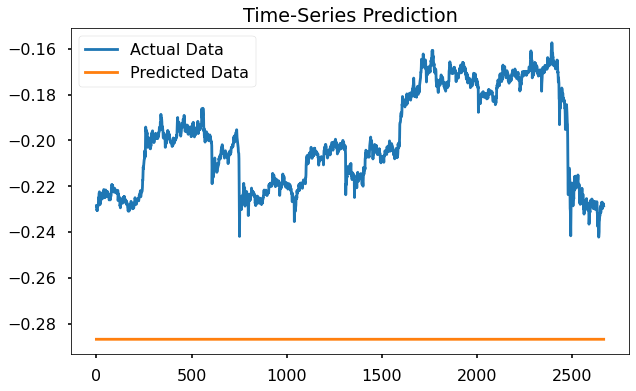

Epoch: 750, train loss: 0.00052, test loss: 0.00804


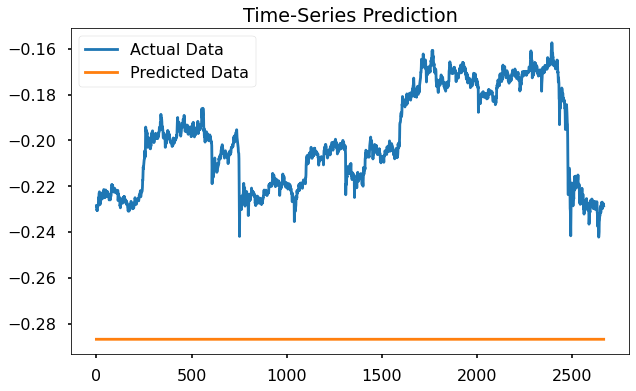

Epoch: 760, train loss: 0.00052, test loss: 0.00804


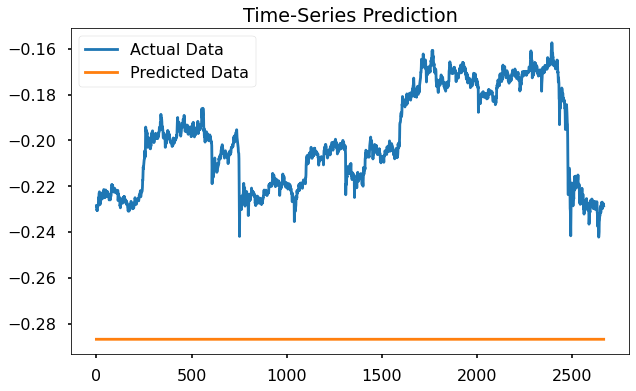

Epoch: 770, train loss: 0.00052, test loss: 0.00804


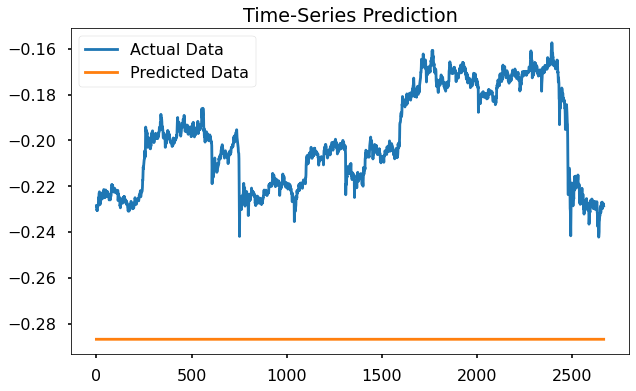

Epoch: 780, train loss: 0.00052, test loss: 0.00804


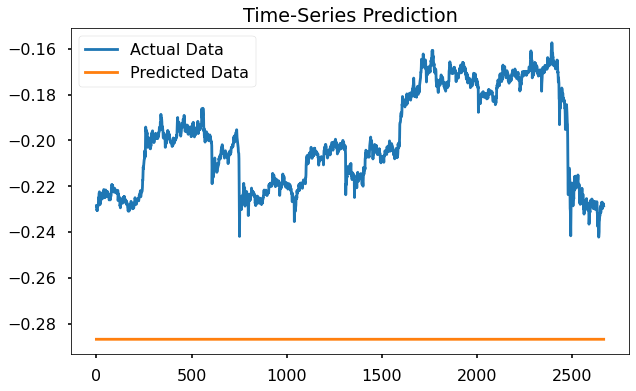

Epoch: 790, train loss: 0.00052, test loss: 0.00804


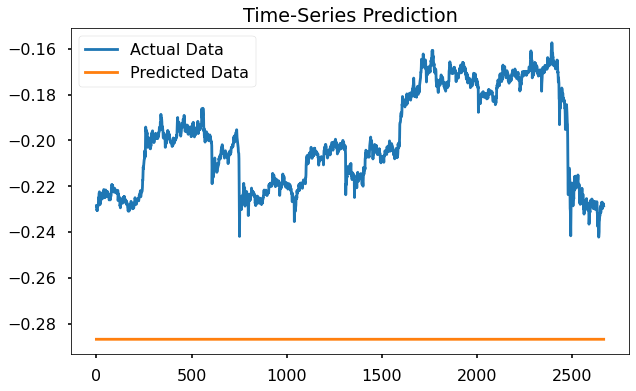

Epoch: 800, train loss: 0.00052, test loss: 0.00804


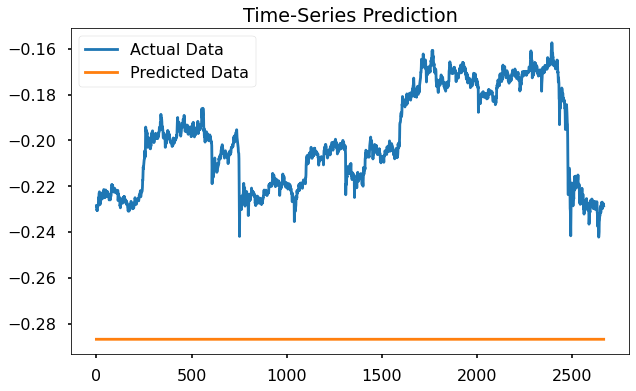

Epoch: 810, train loss: 0.00052, test loss: 0.00804


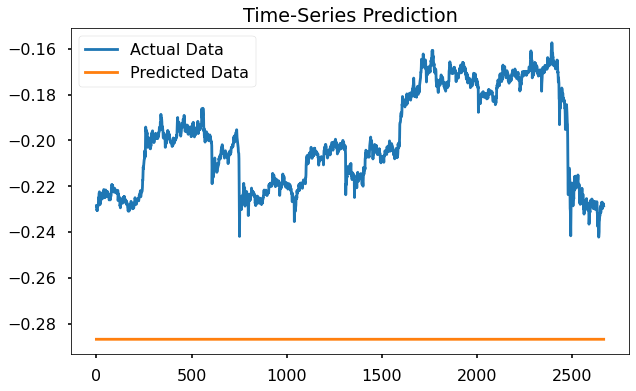

Epoch: 820, train loss: 0.00052, test loss: 0.00804


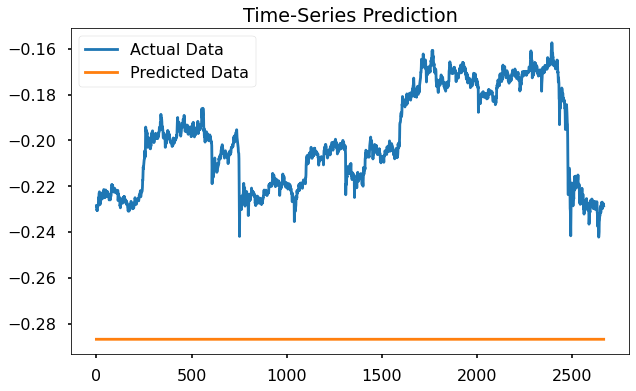

Epoch: 830, train loss: 0.00052, test loss: 0.00804


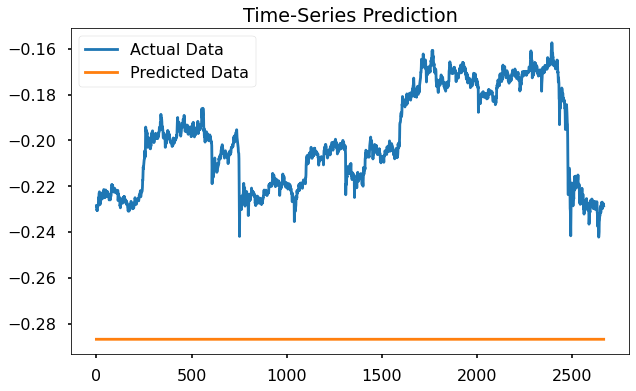

Epoch: 840, train loss: 0.00052, test loss: 0.00804


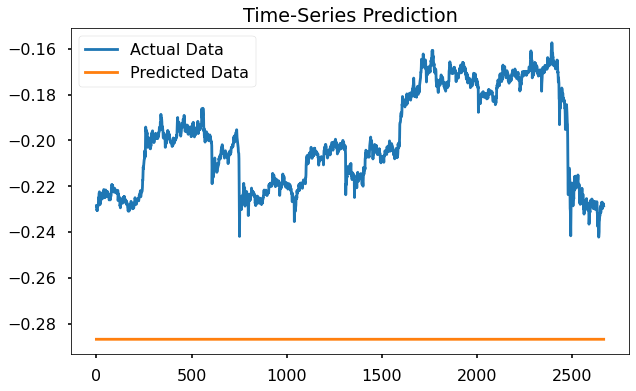

Epoch: 850, train loss: 0.00052, test loss: 0.00804


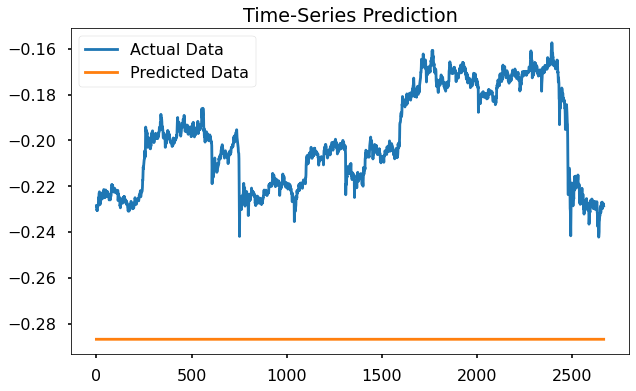

Epoch: 860, train loss: 0.00052, test loss: 0.00804


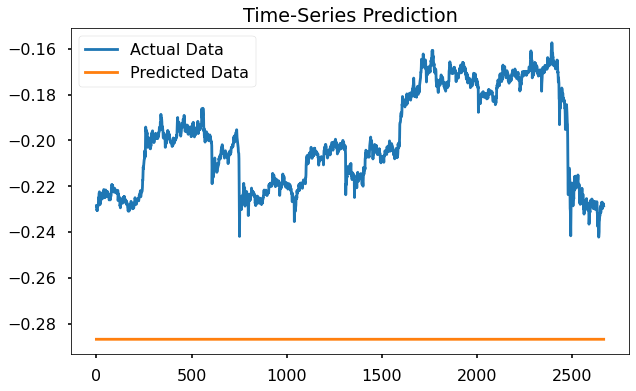

Epoch: 870, train loss: 0.00052, test loss: 0.00804


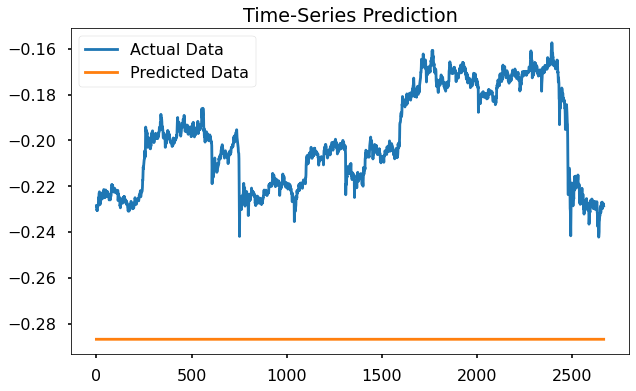

Epoch: 880, train loss: 0.00052, test loss: 0.00804


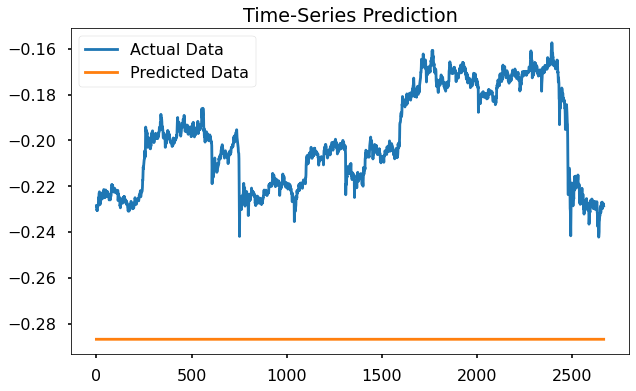

Epoch: 890, train loss: 0.00052, test loss: 0.00804


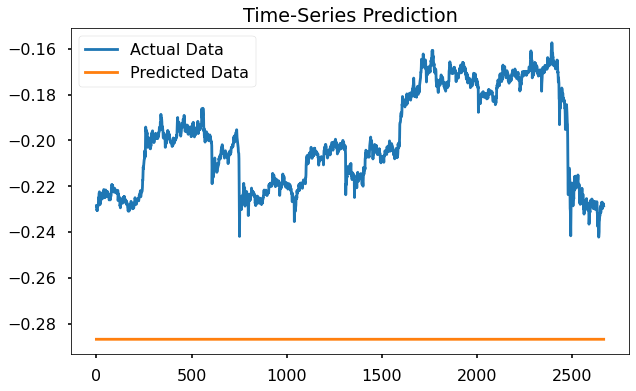

Epoch: 900, train loss: 0.00052, test loss: 0.00804


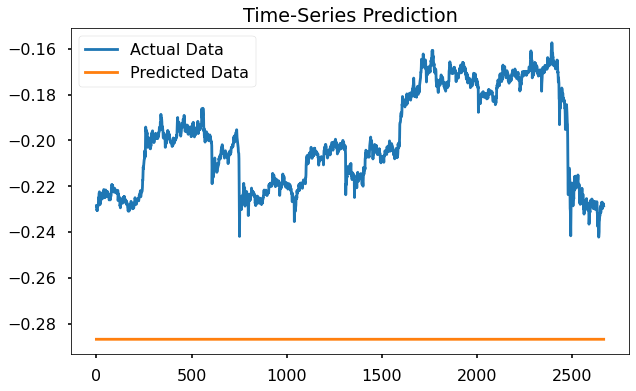

Epoch: 910, train loss: 0.00052, test loss: 0.00804


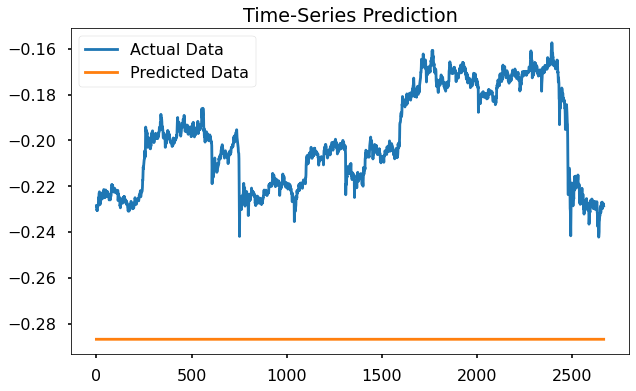

Epoch: 920, train loss: 0.00052, test loss: 0.00804


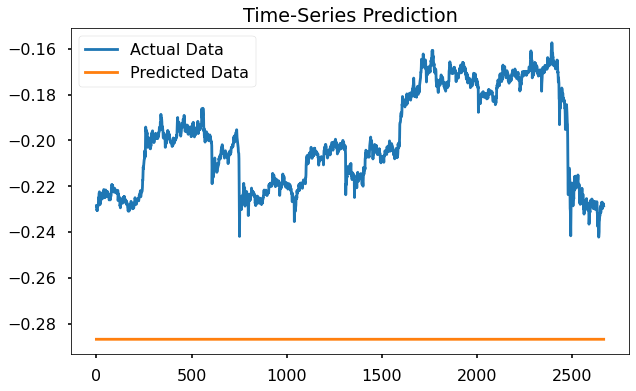

Epoch: 930, train loss: 0.00052, test loss: 0.00804


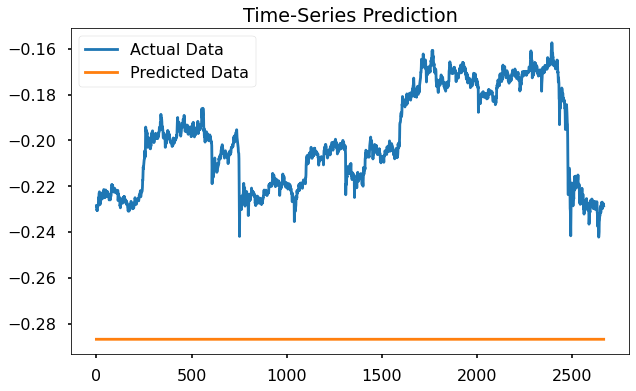

Epoch: 940, train loss: 0.00052, test loss: 0.00804


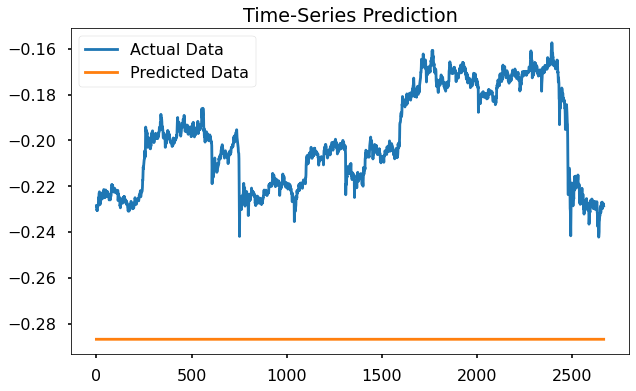

Epoch: 950, train loss: 0.00052, test loss: 0.00804


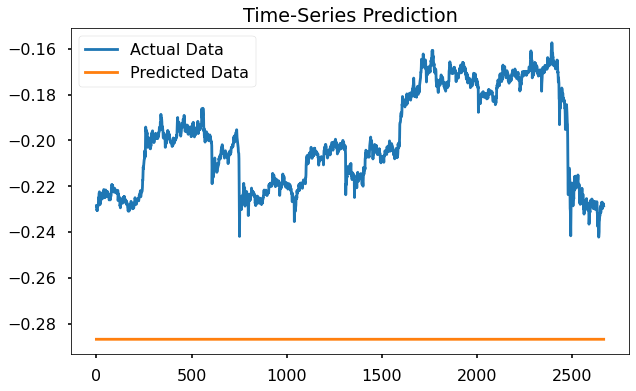

Epoch: 960, train loss: 0.00052, test loss: 0.00804


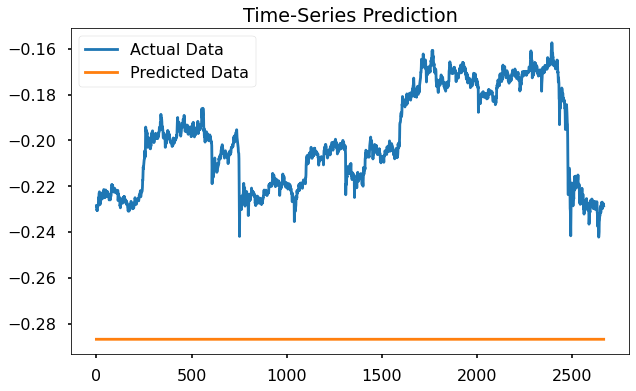

Epoch: 970, train loss: 0.00052, test loss: 0.00804


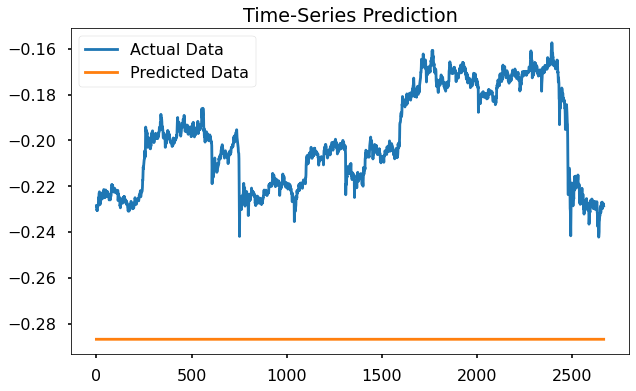

Epoch: 980, train loss: 0.00052, test loss: 0.00804


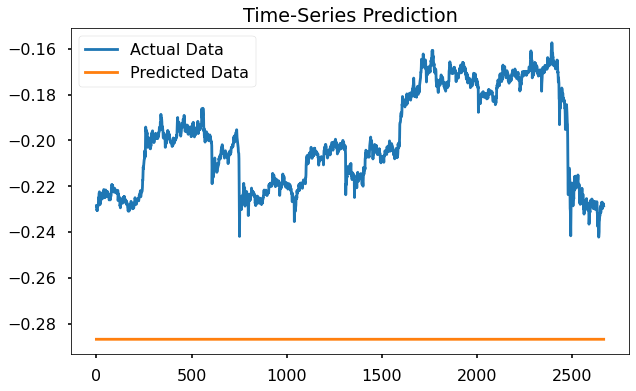

Epoch: 990, train loss: 0.00052, test loss: 0.00804


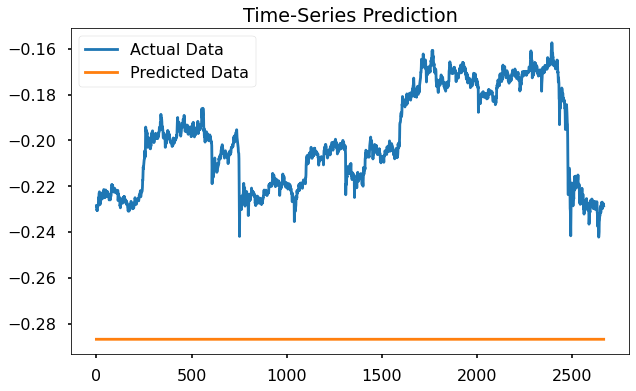

TRAIN: [   0    1    2 ... 5331 5332 5333] TEST: [5334 5335 5336 ... 7997 7998 7999]
Epoch: 0, train loss: 0.00428, test loss: 0.00043


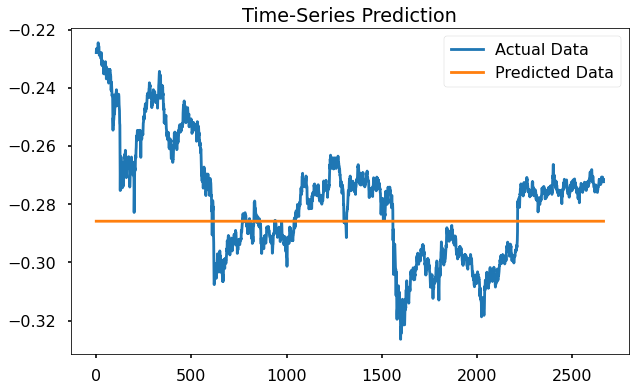

Epoch: 10, train loss: 0.00248, test loss: 0.00127


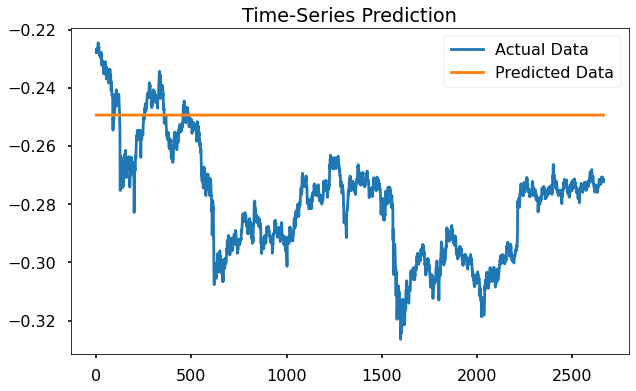

Epoch: 20, train loss: 0.00257, test loss: 0.00289


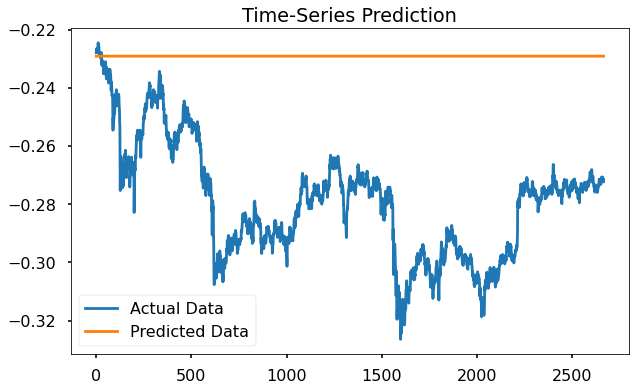

Epoch: 30, train loss: 0.00241, test loss: 0.00197


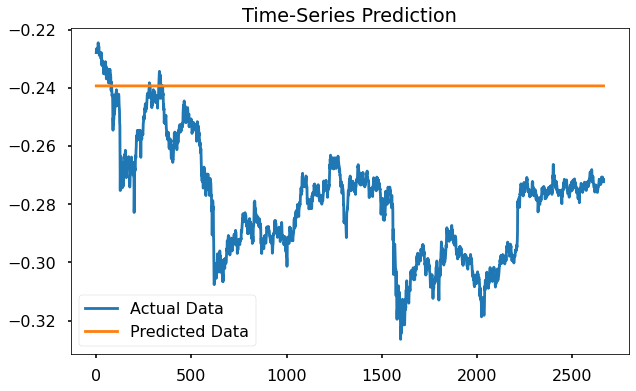

Epoch: 40, train loss: 0.00240, test loss: 0.00137


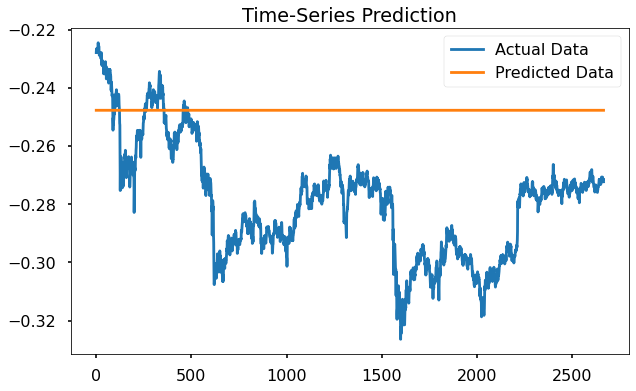

Epoch: 50, train loss: 0.00238, test loss: 0.00155


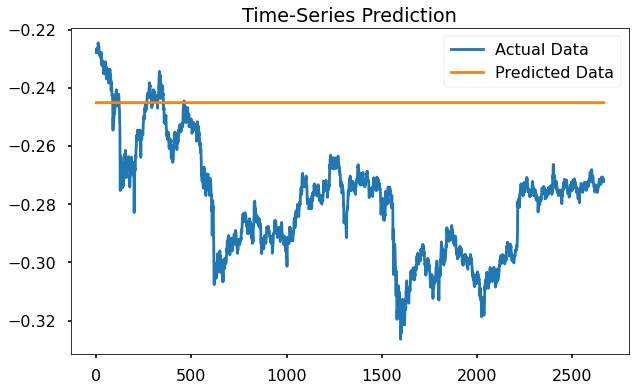

Epoch: 60, train loss: 0.00238, test loss: 0.00178


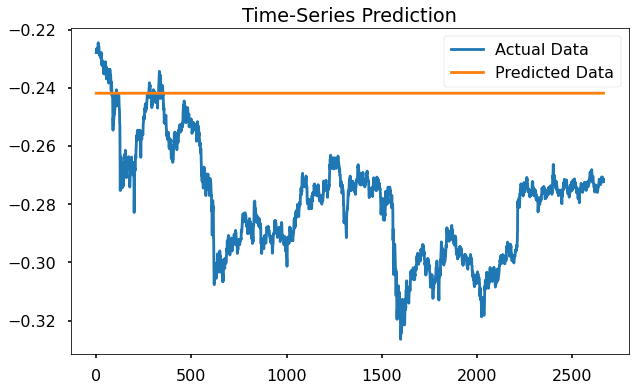

Epoch: 70, train loss: 0.00238, test loss: 0.00173


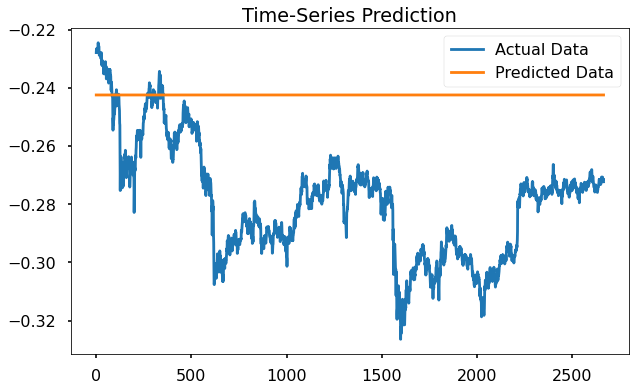

Epoch: 80, train loss: 0.00238, test loss: 0.00165


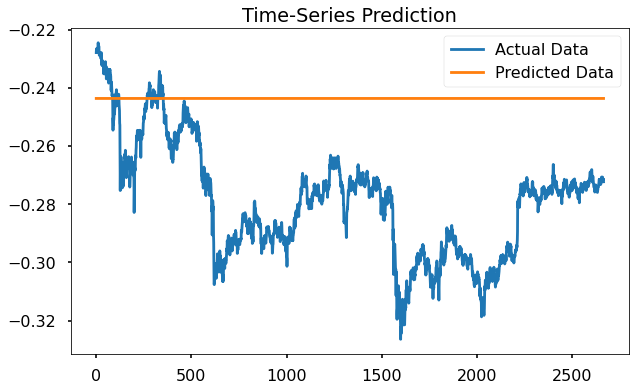

Epoch: 90, train loss: 0.00238, test loss: 0.00165


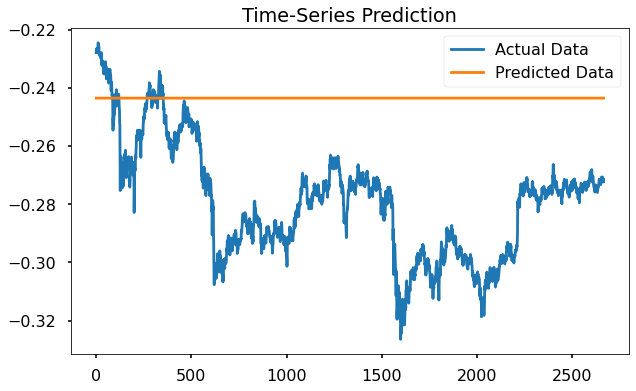

Epoch: 100, train loss: 0.00238, test loss: 0.00169


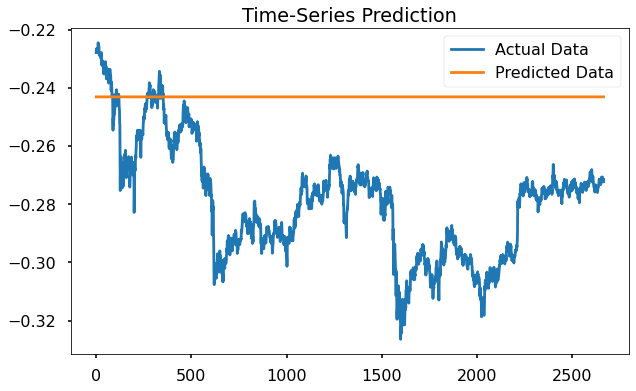

Epoch: 110, train loss: 0.00238, test loss: 0.00168


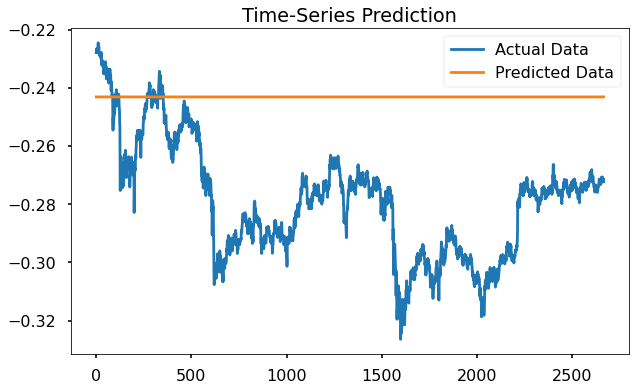

Epoch: 120, train loss: 0.00238, test loss: 0.00167


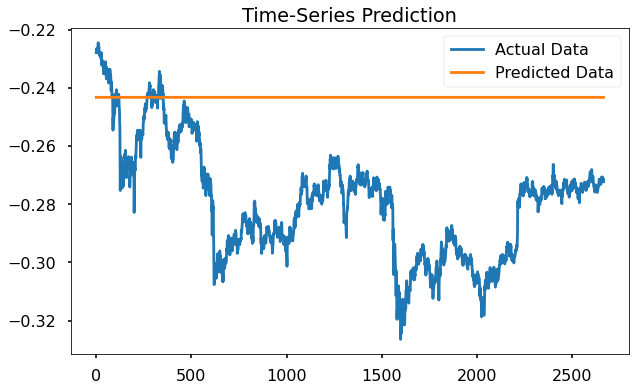

Epoch: 130, train loss: 0.00238, test loss: 0.00167


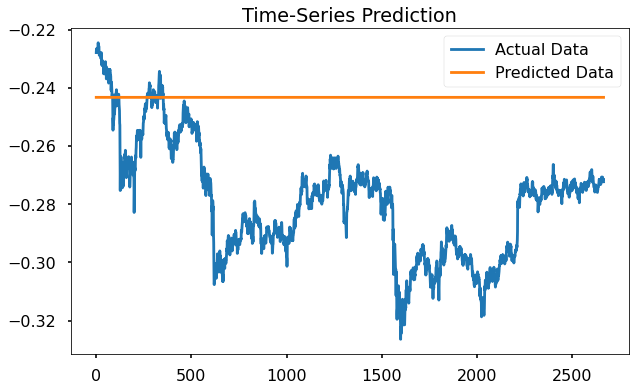

Epoch: 140, train loss: 0.00238, test loss: 0.00168


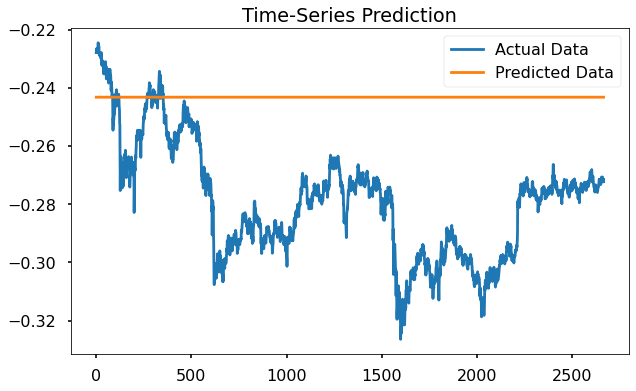

Epoch: 150, train loss: 0.00238, test loss: 0.00168


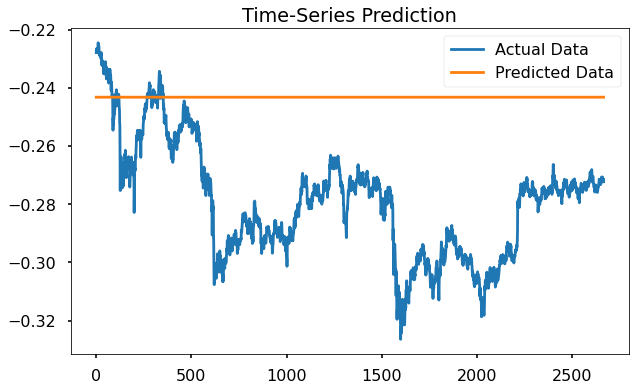

Epoch: 160, train loss: 0.00238, test loss: 0.00168


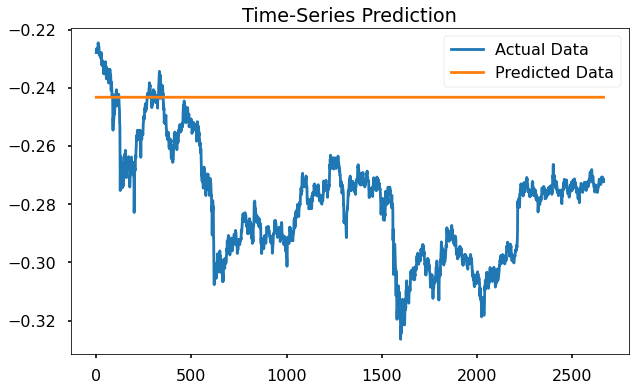

Epoch: 170, train loss: 0.00238, test loss: 0.00168


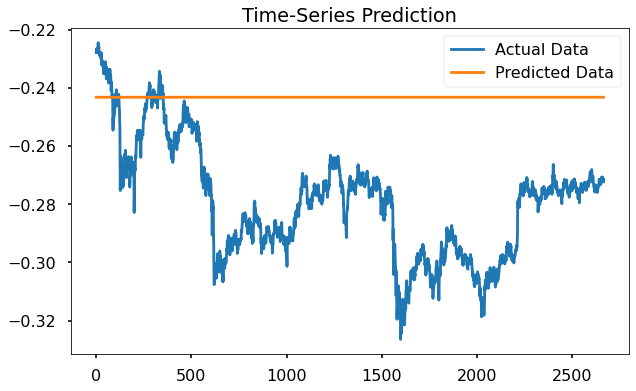

Epoch: 180, train loss: 0.00238, test loss: 0.00168


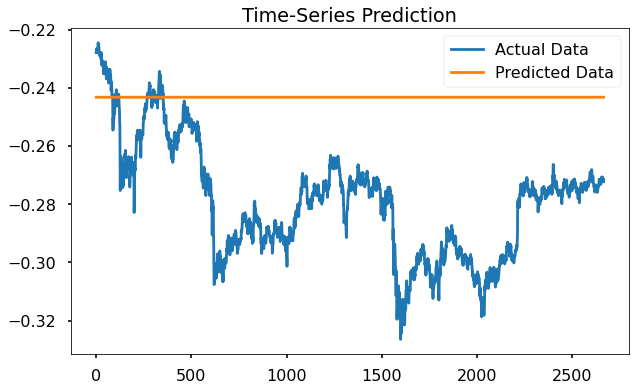

Epoch: 190, train loss: 0.00238, test loss: 0.00168


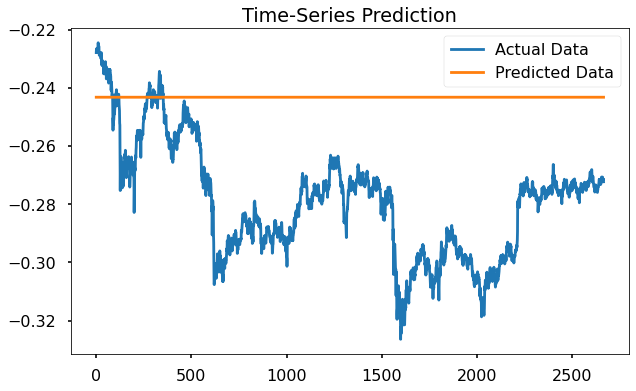

Epoch: 200, train loss: 0.00238, test loss: 0.00168


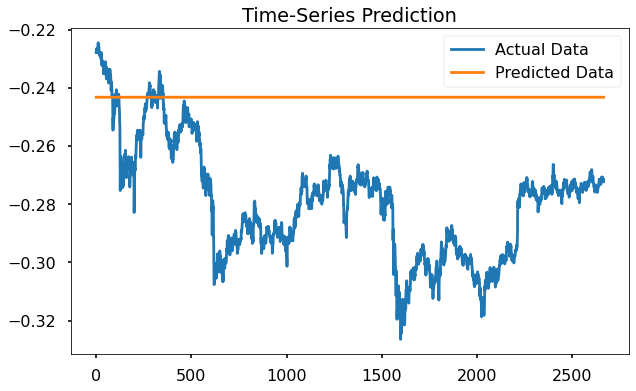

Epoch: 210, train loss: 0.00238, test loss: 0.00168


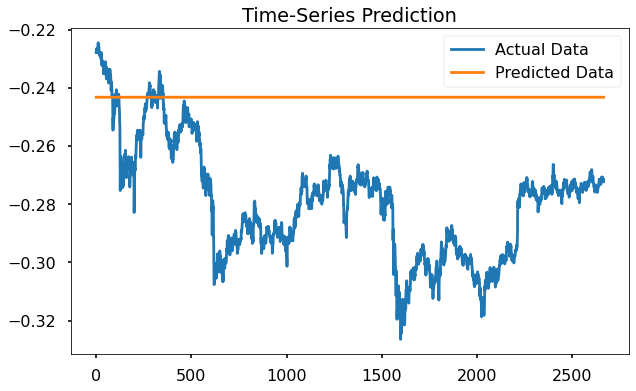

Epoch: 220, train loss: 0.00238, test loss: 0.00168


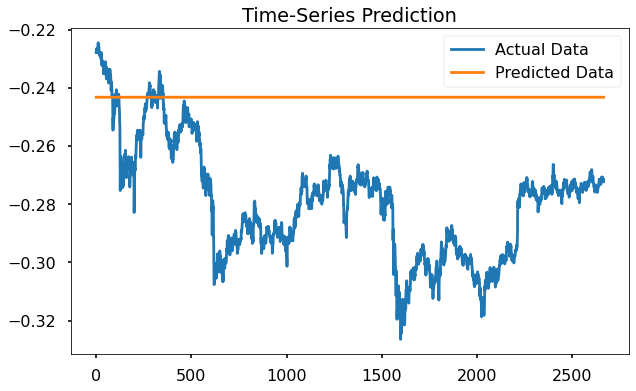

Epoch: 230, train loss: 0.00238, test loss: 0.00168


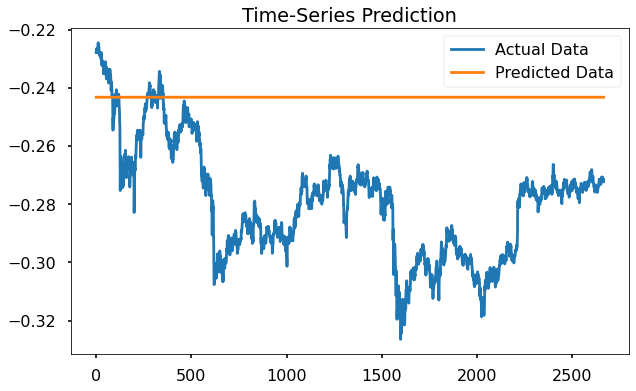

Epoch: 240, train loss: 0.00238, test loss: 0.00168


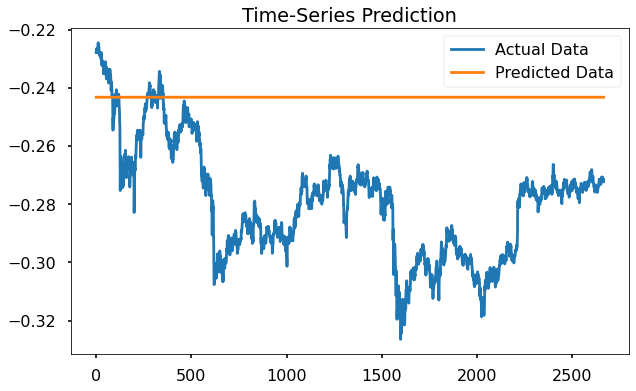

Epoch: 250, train loss: 0.00238, test loss: 0.00168


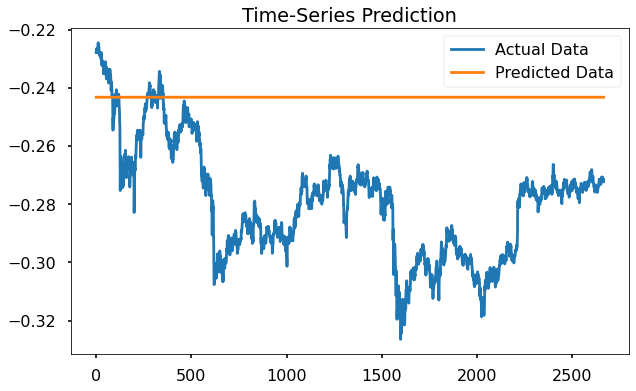

Epoch: 260, train loss: 0.00238, test loss: 0.00168


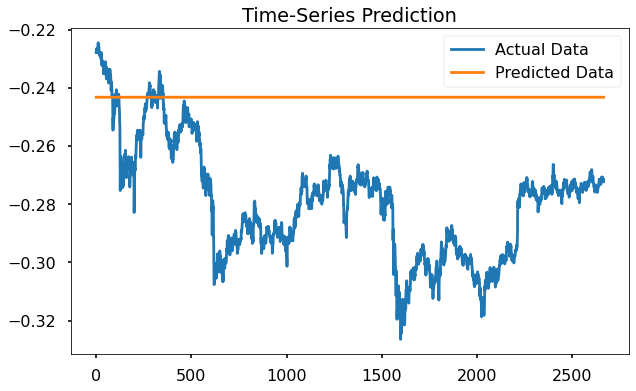

Epoch: 270, train loss: 0.00238, test loss: 0.00168


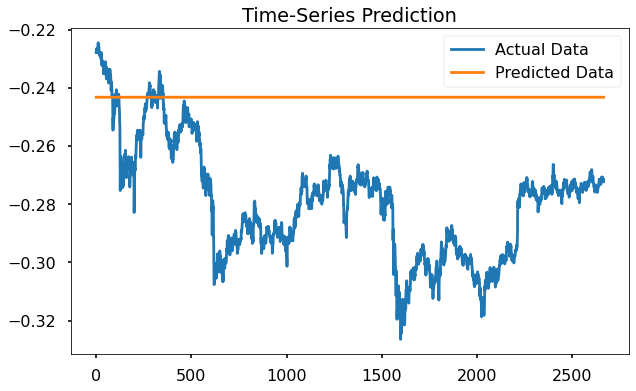

Epoch: 280, train loss: 0.00238, test loss: 0.00168


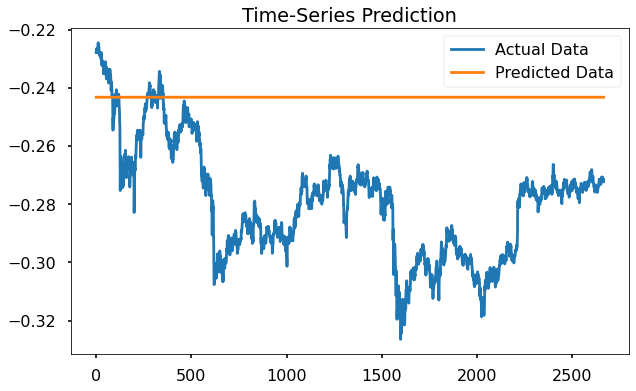

Epoch: 290, train loss: 0.00238, test loss: 0.00168


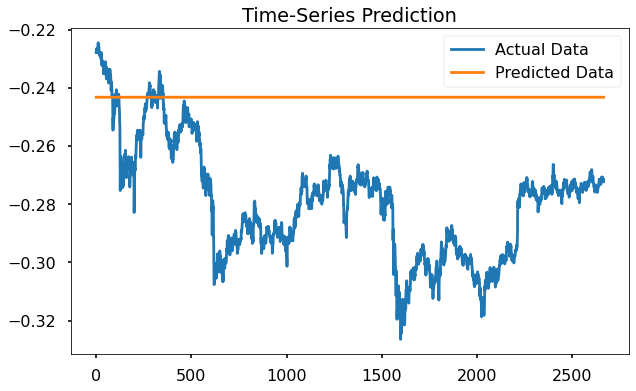

Epoch: 300, train loss: 0.00238, test loss: 0.00168


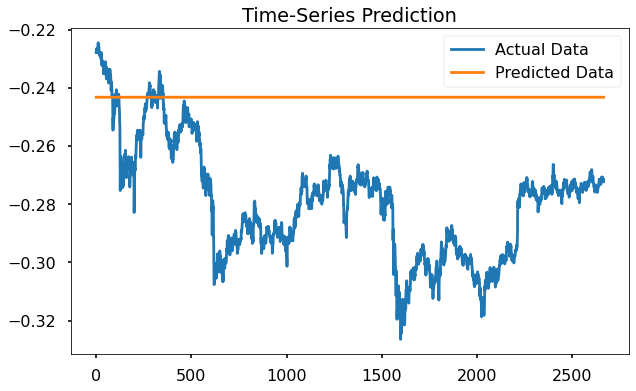

Epoch: 310, train loss: 0.00238, test loss: 0.00168


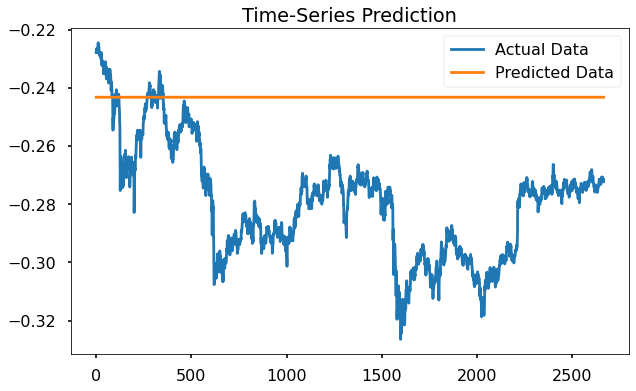

Epoch: 320, train loss: 0.00238, test loss: 0.00168


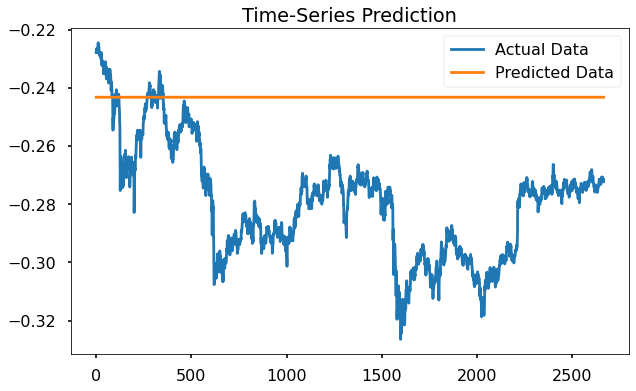

Epoch: 330, train loss: 0.00238, test loss: 0.00168


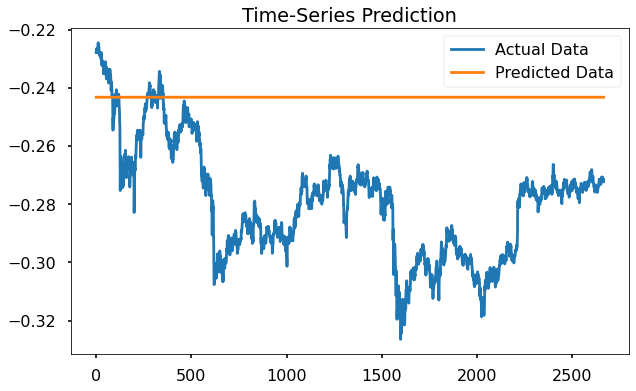

Epoch: 340, train loss: 0.00238, test loss: 0.00168


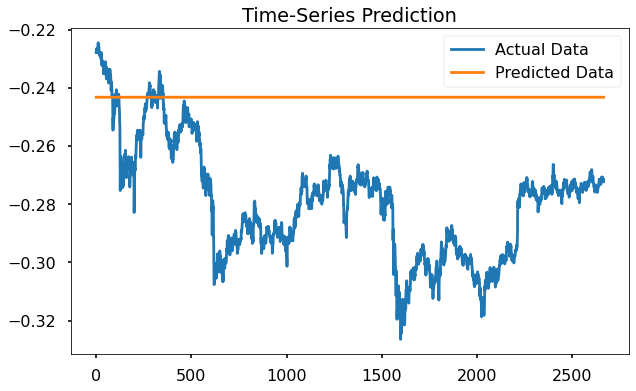

Epoch: 350, train loss: 0.00238, test loss: 0.00168


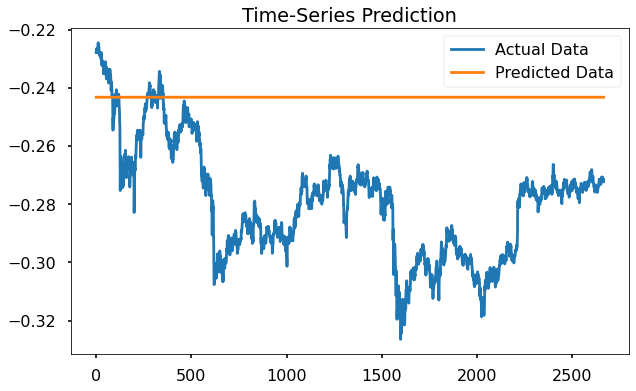

Epoch: 360, train loss: 0.00238, test loss: 0.00168


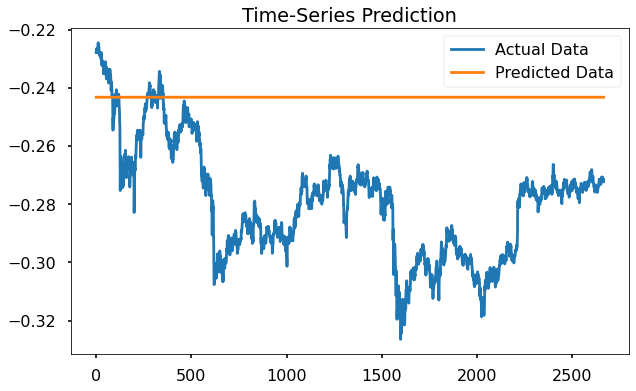

Epoch: 370, train loss: 0.00238, test loss: 0.00168


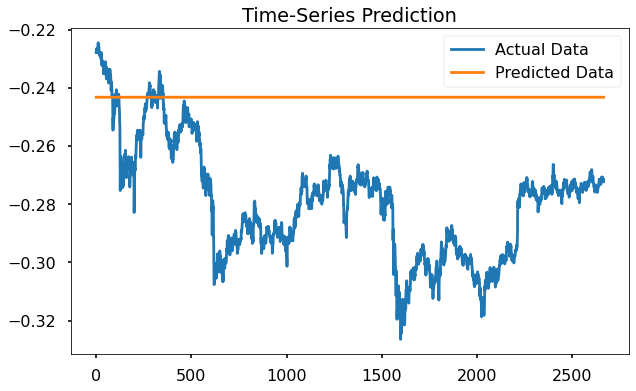

Epoch: 380, train loss: 0.00238, test loss: 0.00168


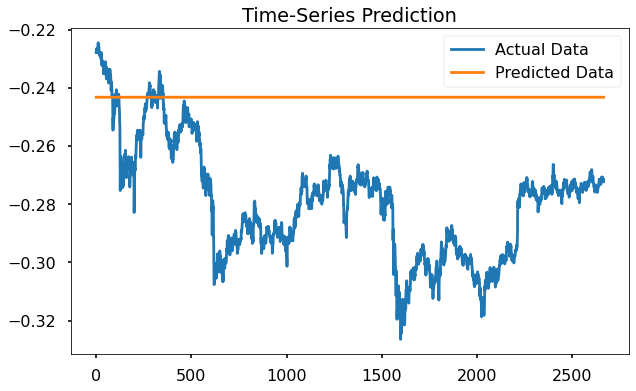

Epoch: 390, train loss: 0.00238, test loss: 0.00168


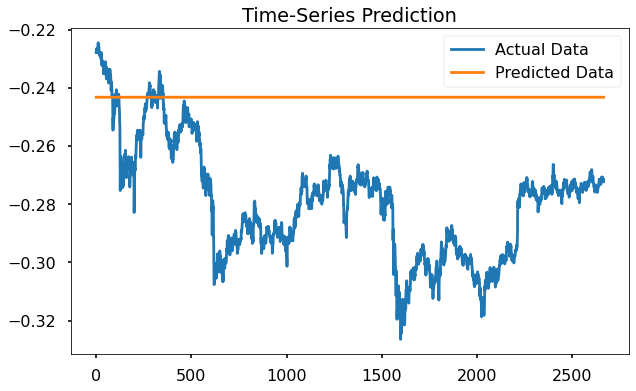

Epoch: 400, train loss: 0.00238, test loss: 0.00168


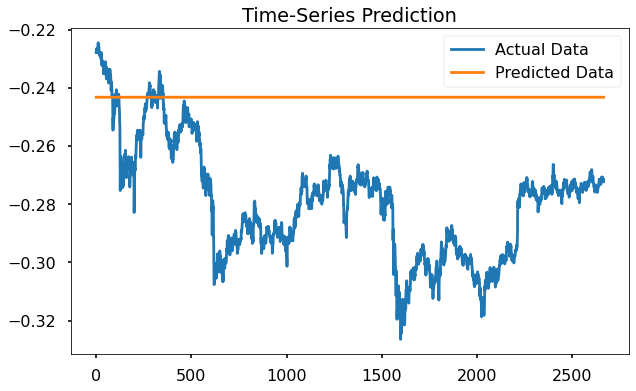

Epoch: 410, train loss: 0.00238, test loss: 0.00168


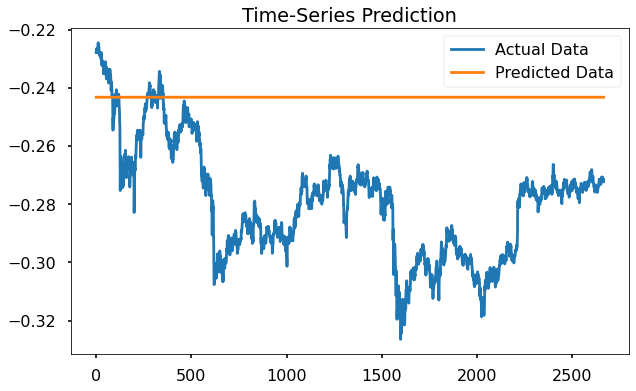

Epoch: 420, train loss: 0.00238, test loss: 0.00168


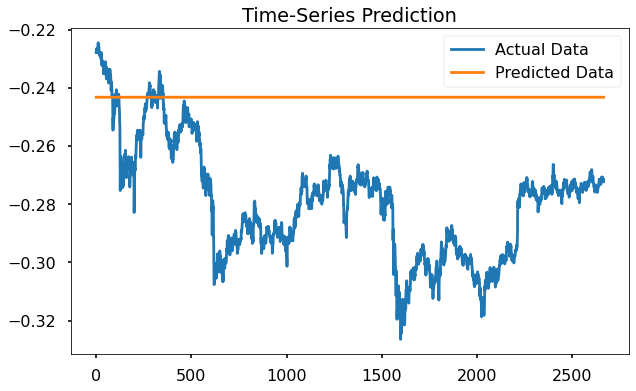

Epoch: 430, train loss: 0.00238, test loss: 0.00168


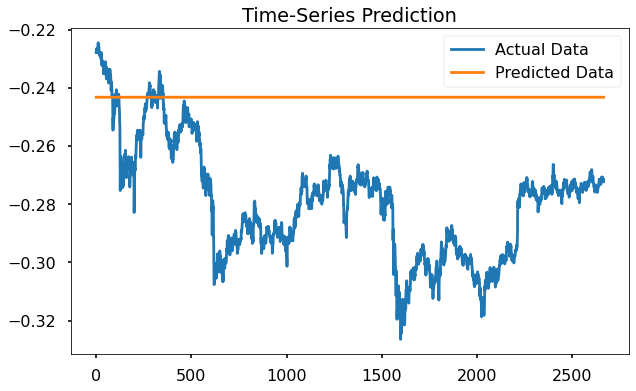

Epoch: 440, train loss: 0.00238, test loss: 0.00168


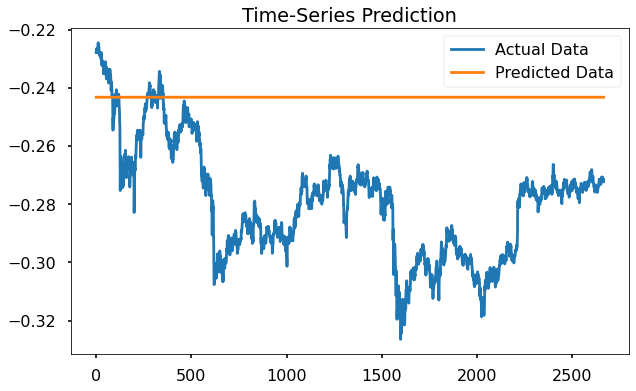

Epoch: 450, train loss: 0.00238, test loss: 0.00168


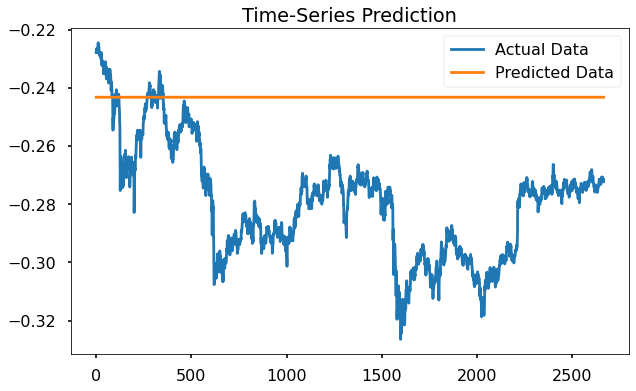

Epoch: 460, train loss: 0.00238, test loss: 0.00168


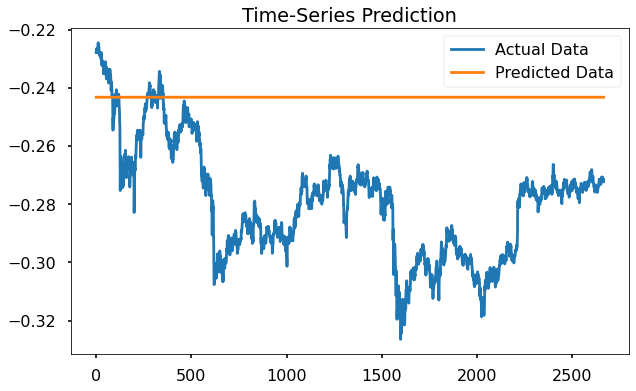

Epoch: 470, train loss: 0.00238, test loss: 0.00168


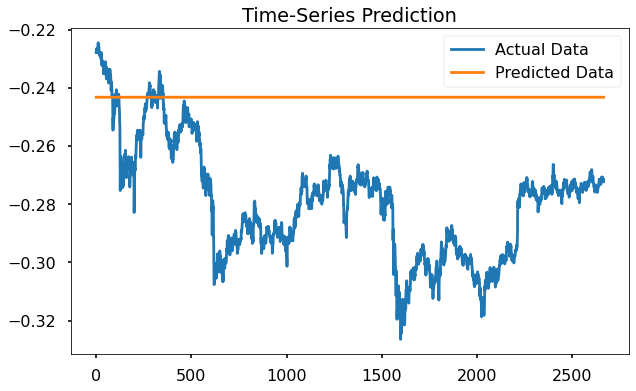

Epoch: 480, train loss: 0.00238, test loss: 0.00168


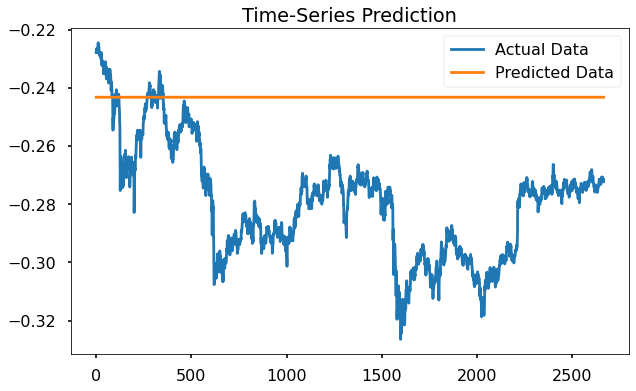

Epoch: 490, train loss: 0.00238, test loss: 0.00168


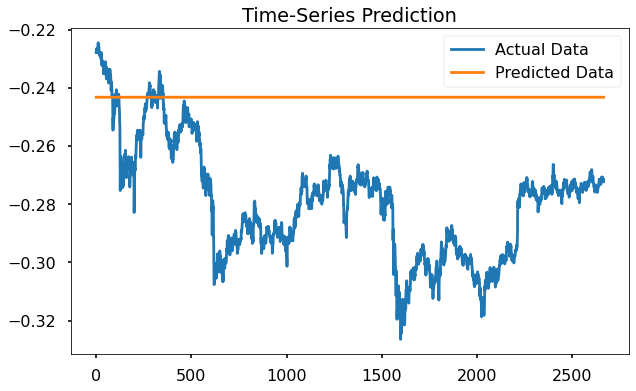

Epoch: 500, train loss: 0.00238, test loss: 0.00168


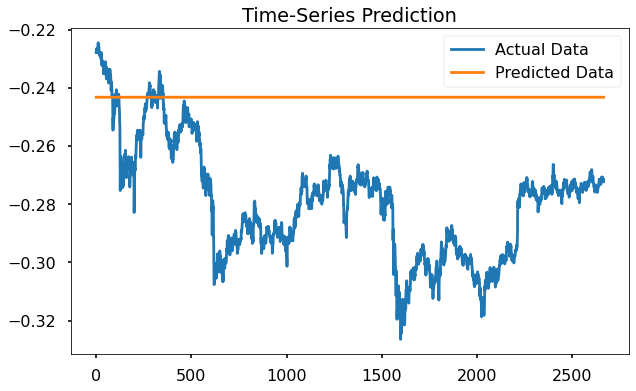

Epoch: 510, train loss: 0.00238, test loss: 0.00168


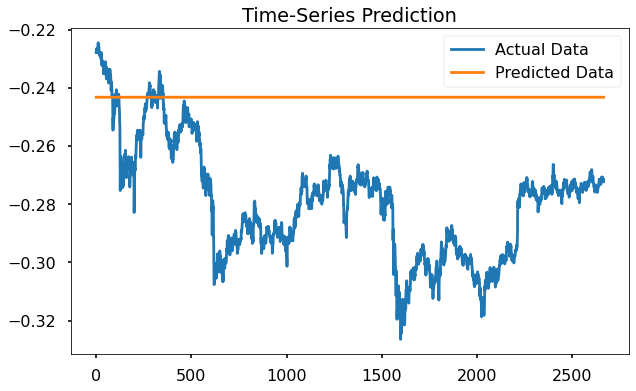

Epoch: 520, train loss: 0.00238, test loss: 0.00168


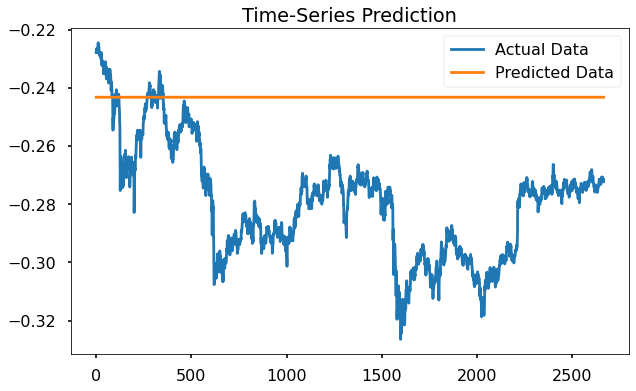

Epoch: 530, train loss: 0.00238, test loss: 0.00168


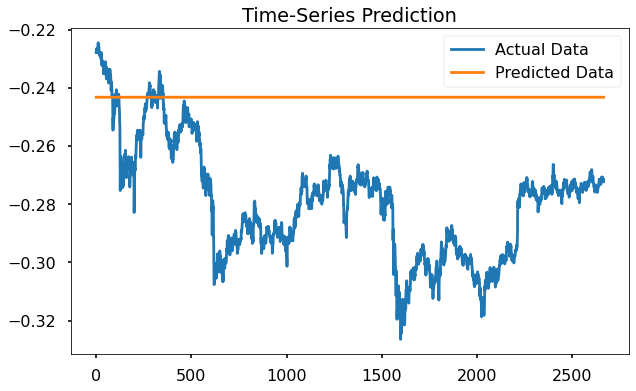

Epoch: 540, train loss: 0.00238, test loss: 0.00168


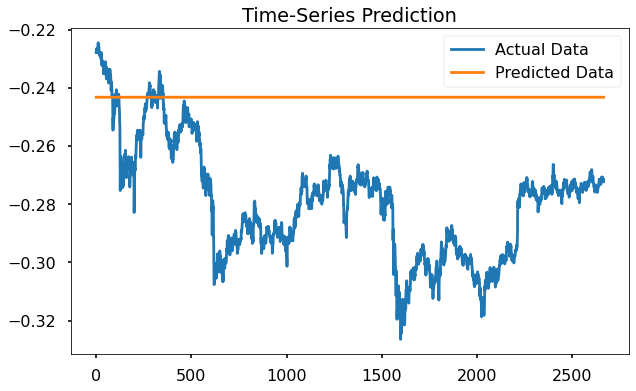

Epoch: 550, train loss: 0.00238, test loss: 0.00168


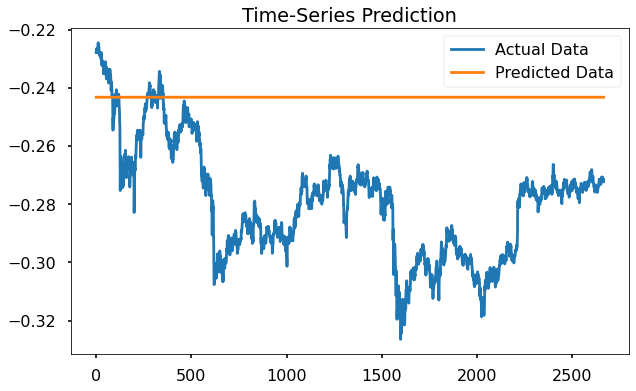

Epoch: 560, train loss: 0.00238, test loss: 0.00168


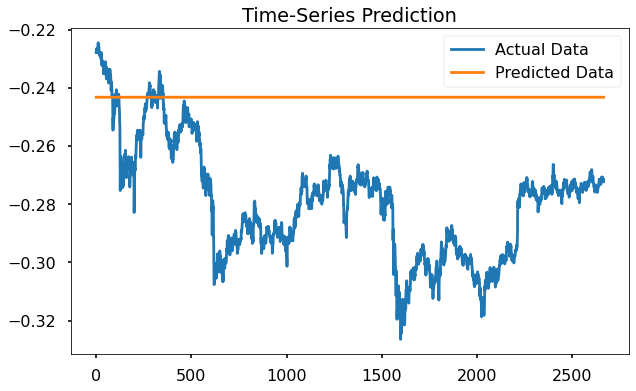

Epoch: 570, train loss: 0.00238, test loss: 0.00168


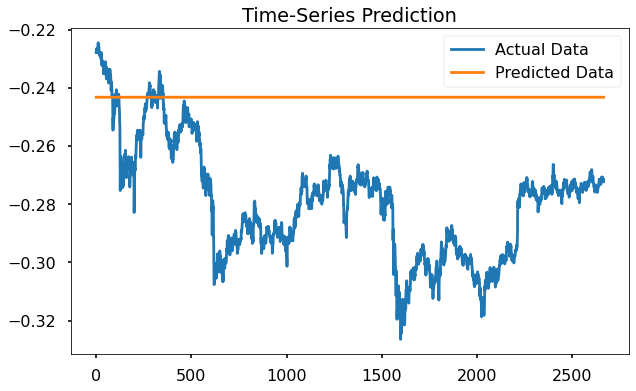

Epoch: 580, train loss: 0.00238, test loss: 0.00168


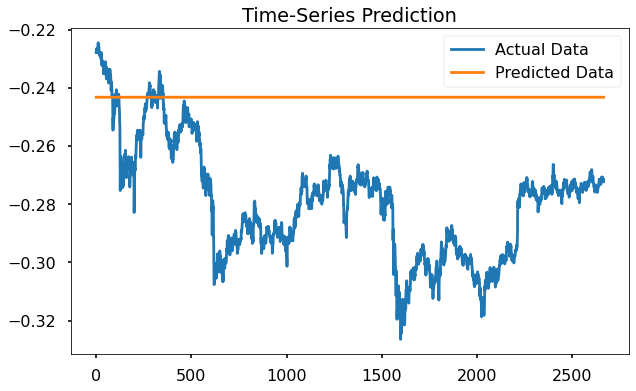

Epoch: 590, train loss: 0.00238, test loss: 0.00168


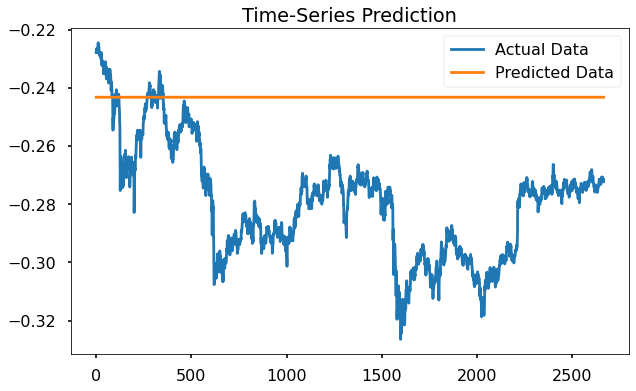

Epoch: 600, train loss: 0.00238, test loss: 0.00168


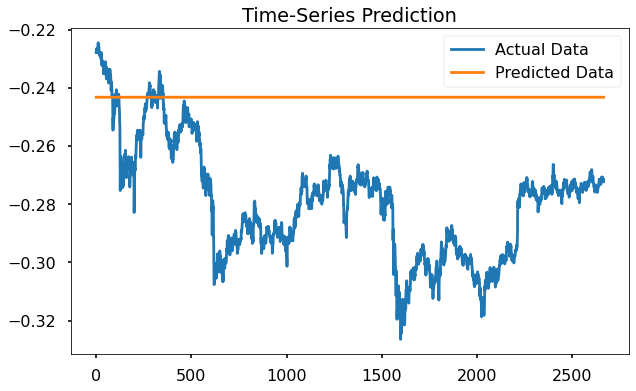

Epoch: 610, train loss: 0.00238, test loss: 0.00168


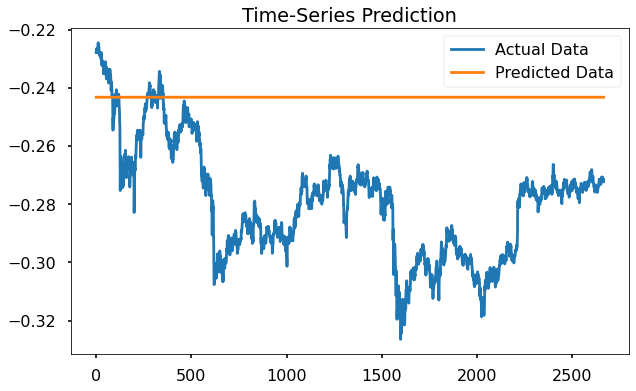

Epoch: 620, train loss: 0.00238, test loss: 0.00168


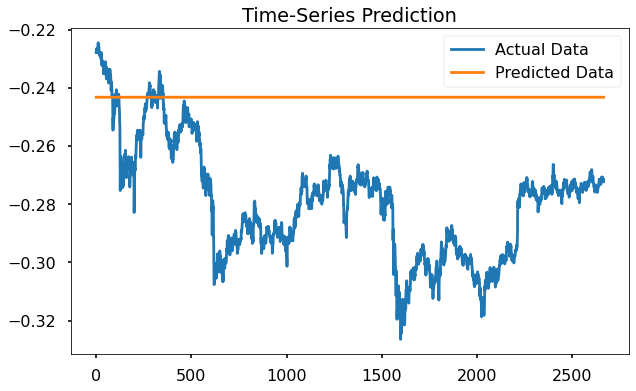

Epoch: 630, train loss: 0.00238, test loss: 0.00168


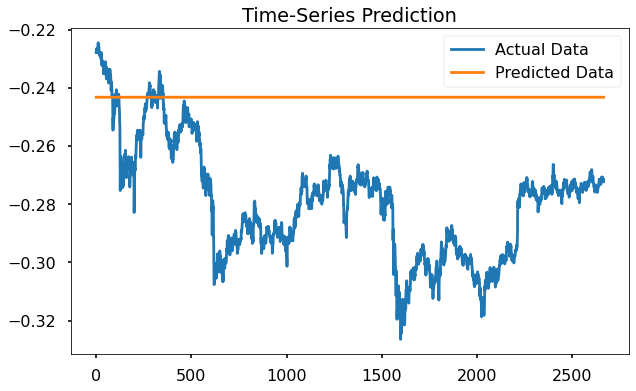

Epoch: 640, train loss: 0.00238, test loss: 0.00168


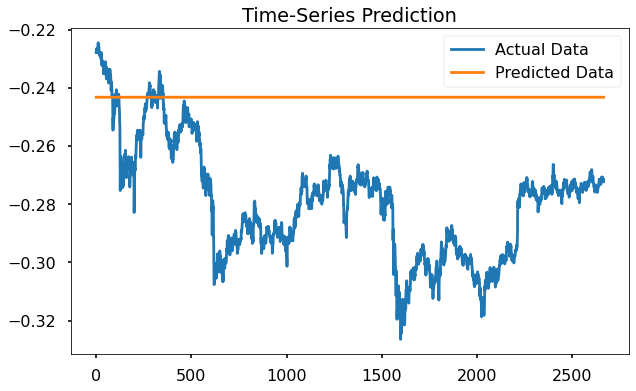

Epoch: 650, train loss: 0.00238, test loss: 0.00168


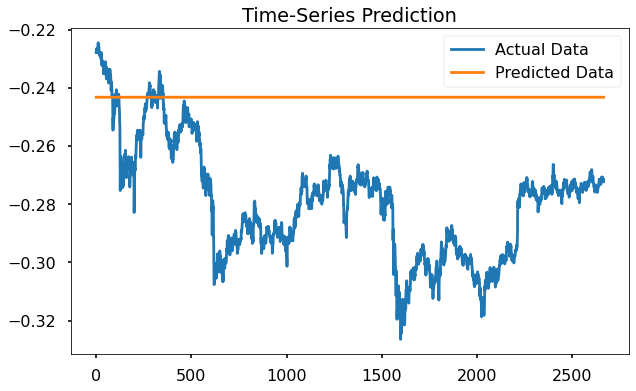

Epoch: 660, train loss: 0.00238, test loss: 0.00168


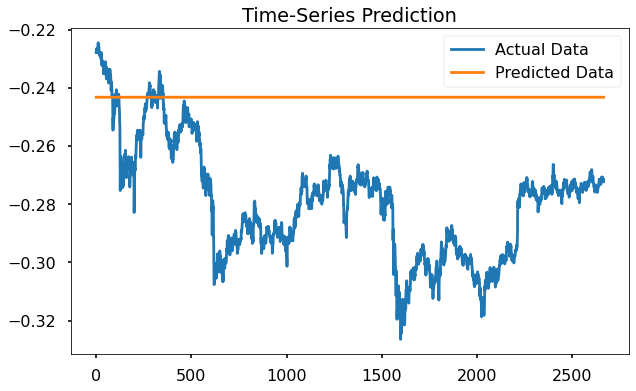

Epoch: 670, train loss: 0.00238, test loss: 0.00168


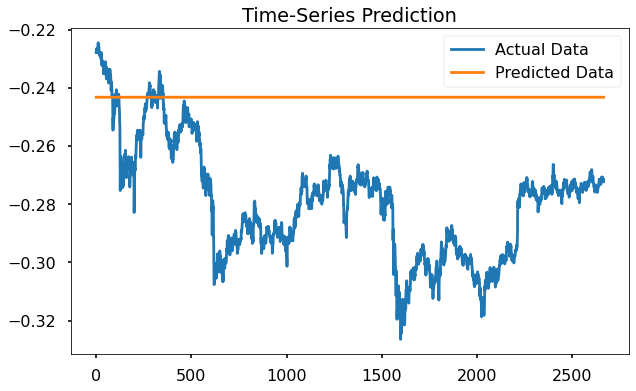

Epoch: 680, train loss: 0.00238, test loss: 0.00168


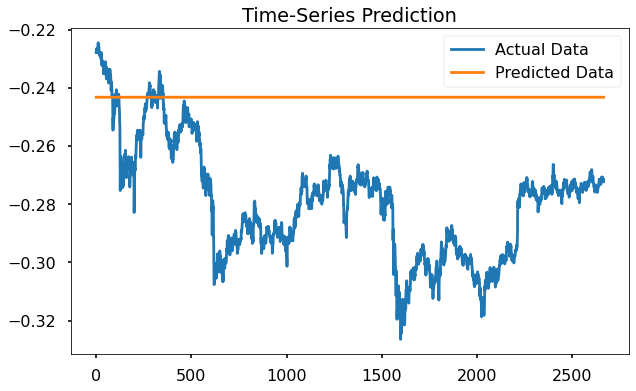

Epoch: 690, train loss: 0.00238, test loss: 0.00168


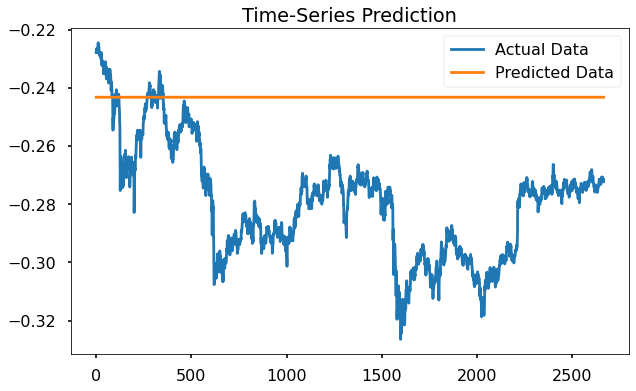

Epoch: 700, train loss: 0.00238, test loss: 0.00168


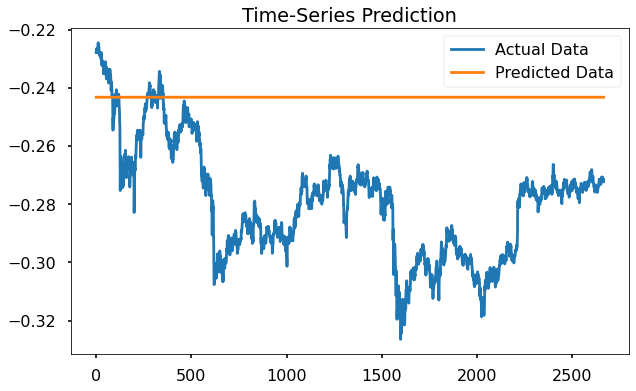

Epoch: 710, train loss: 0.00238, test loss: 0.00168


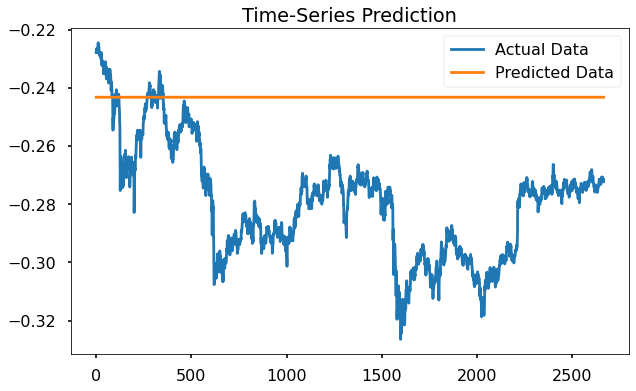

Epoch: 720, train loss: 0.00238, test loss: 0.00168


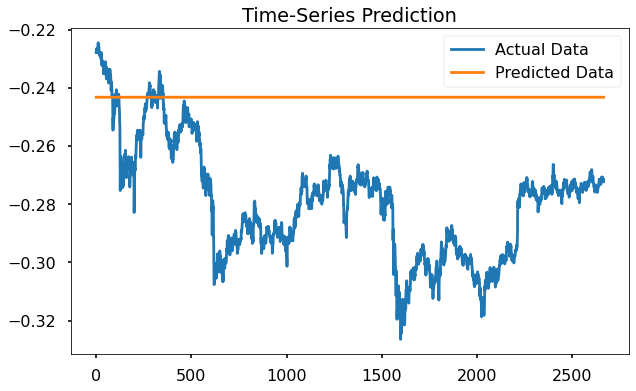

Epoch: 730, train loss: 0.00238, test loss: 0.00168


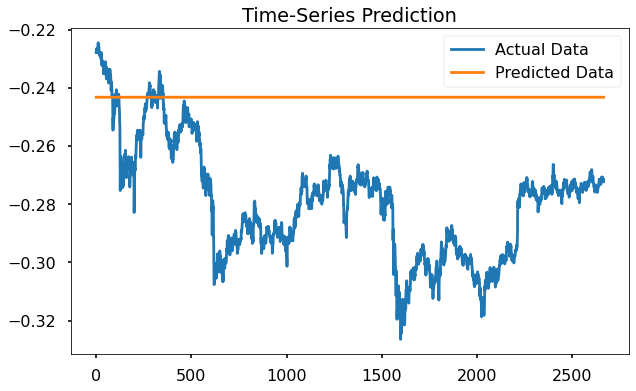

Epoch: 740, train loss: 0.00238, test loss: 0.00168


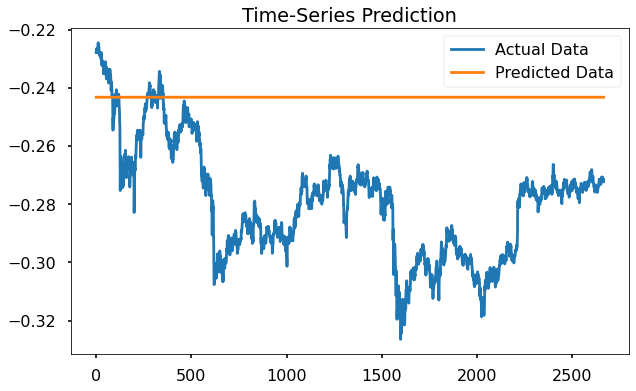

Epoch: 750, train loss: 0.00238, test loss: 0.00168


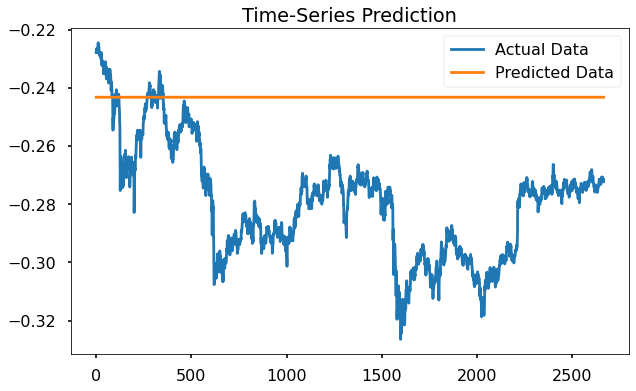

Epoch: 760, train loss: 0.00238, test loss: 0.00168


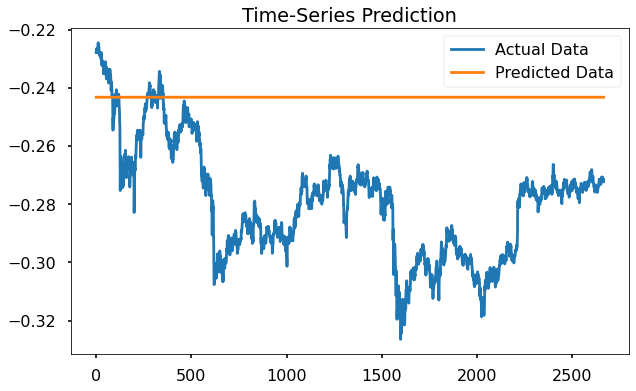

Epoch: 770, train loss: 0.00238, test loss: 0.00168


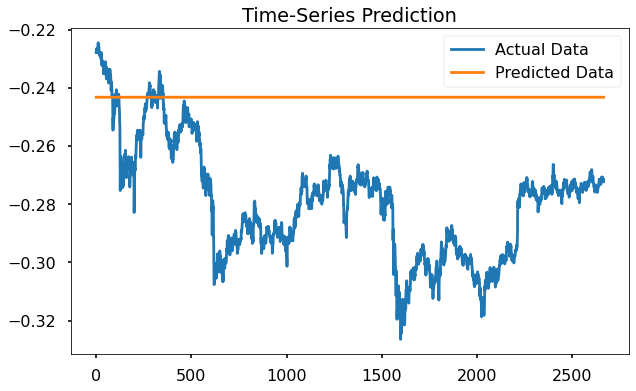

Epoch: 780, train loss: 0.00238, test loss: 0.00168


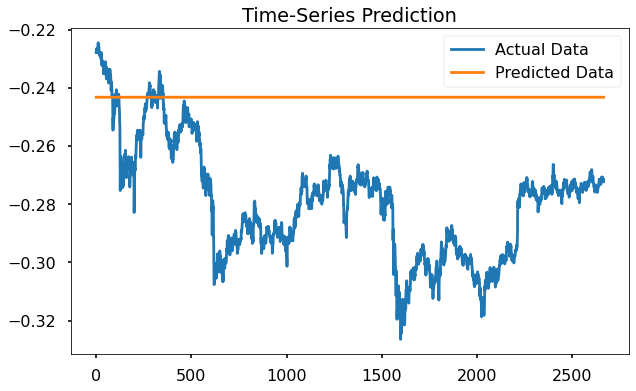

Epoch: 790, train loss: 0.00238, test loss: 0.00168


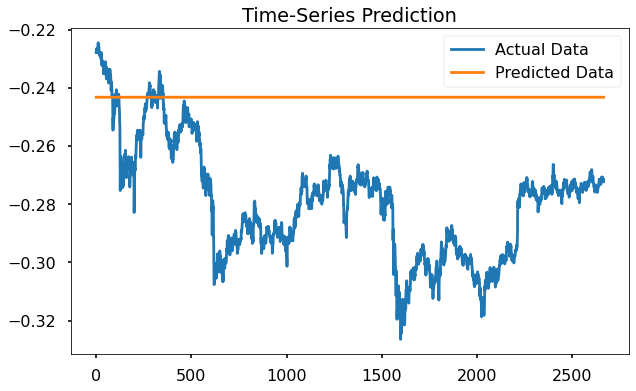

Epoch: 800, train loss: 0.00238, test loss: 0.00168


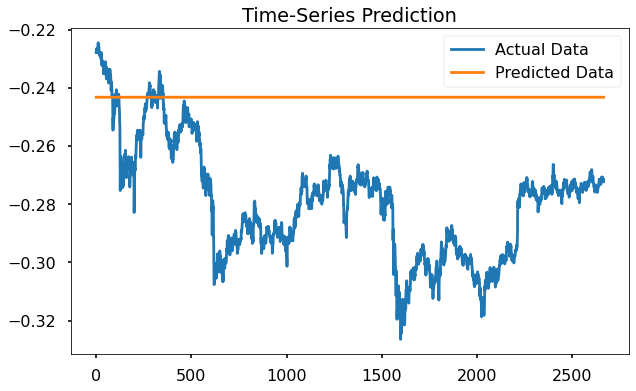

Epoch: 810, train loss: 0.00238, test loss: 0.00168


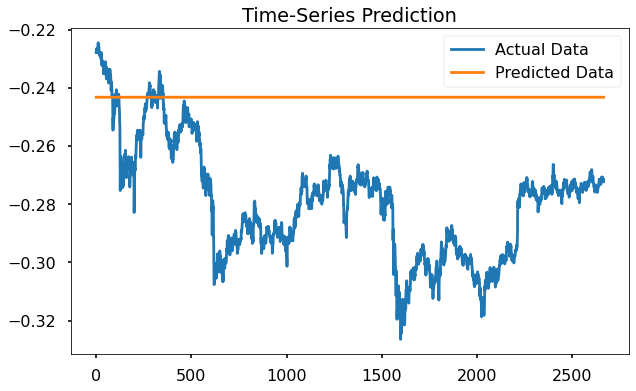

Epoch: 820, train loss: 0.00238, test loss: 0.00168


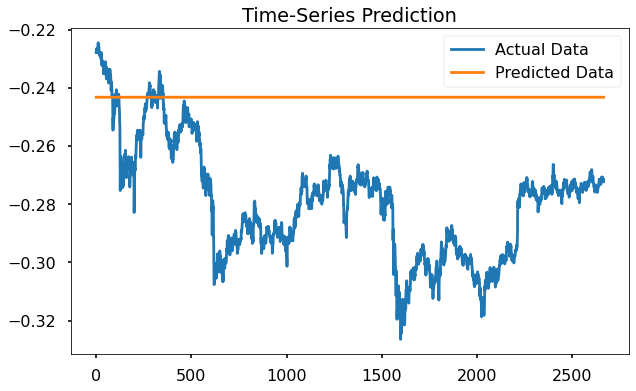

Epoch: 830, train loss: 0.00238, test loss: 0.00168


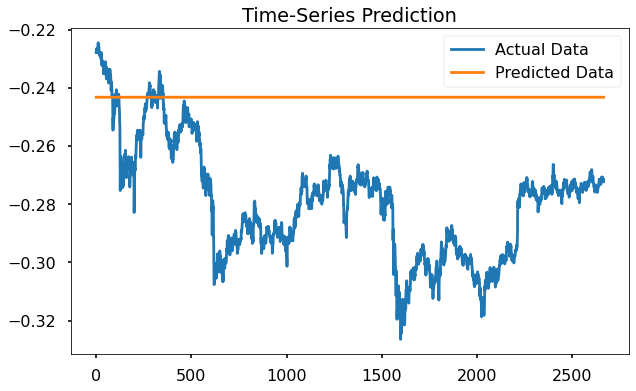

Epoch: 840, train loss: 0.00238, test loss: 0.00168


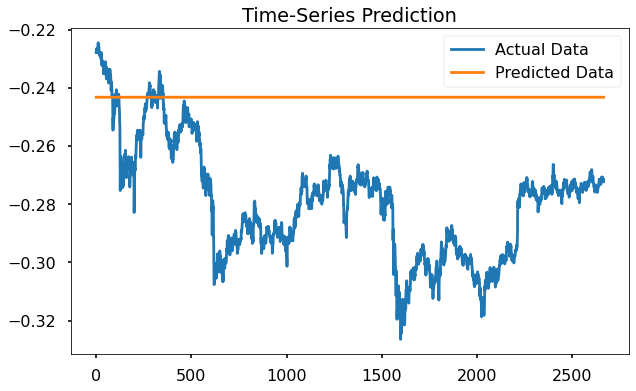

Epoch: 850, train loss: 0.00238, test loss: 0.00168


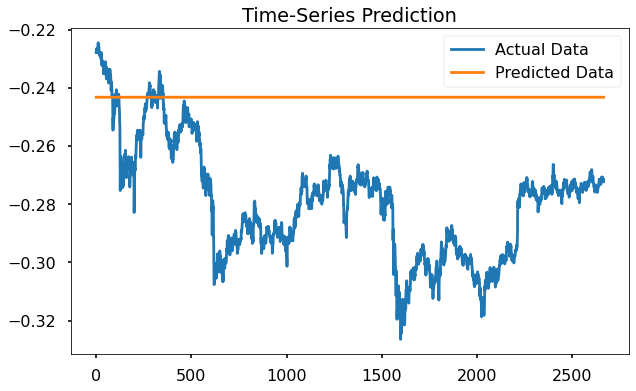

Epoch: 860, train loss: 0.00238, test loss: 0.00168


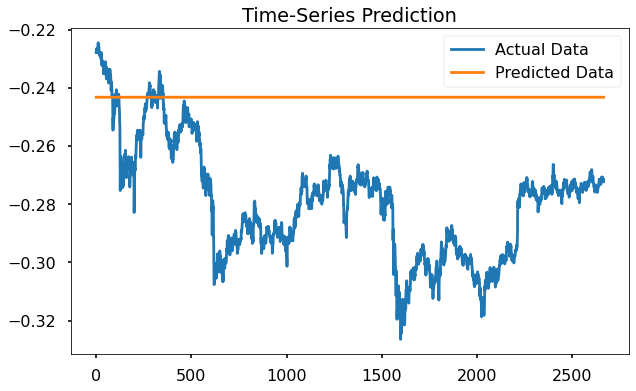

Epoch: 870, train loss: 0.00238, test loss: 0.00168


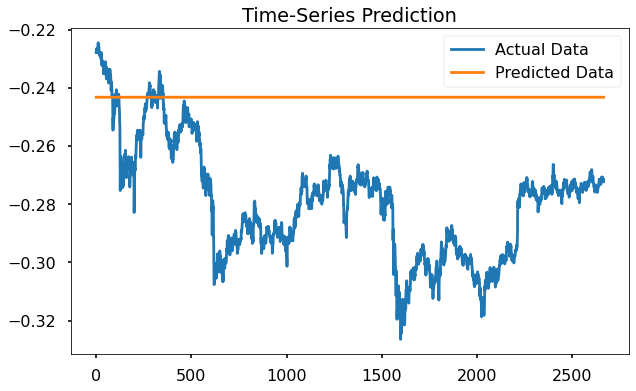

Epoch: 880, train loss: 0.00238, test loss: 0.00168


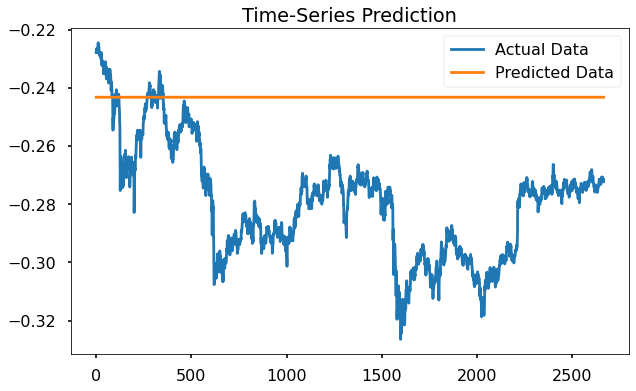

Epoch: 890, train loss: 0.00238, test loss: 0.00168


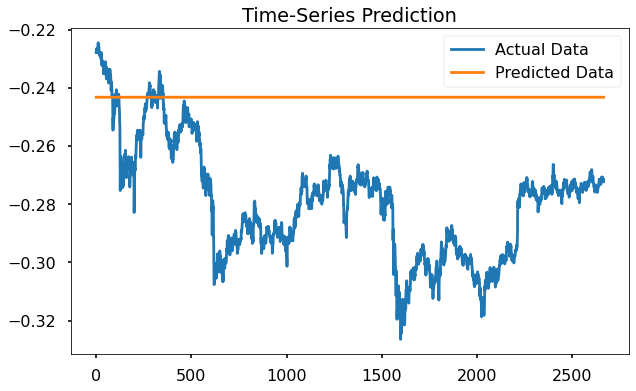

Epoch: 900, train loss: 0.00238, test loss: 0.00168


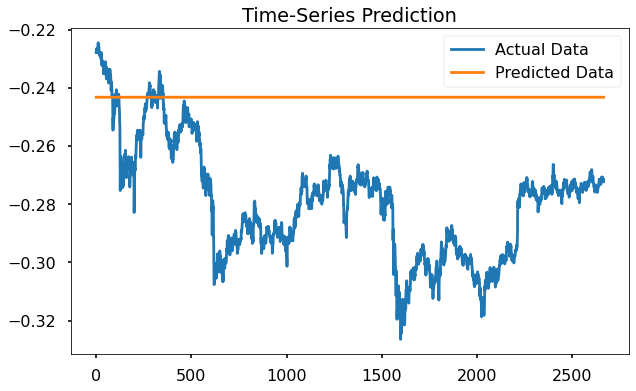

Epoch: 910, train loss: 0.00238, test loss: 0.00168


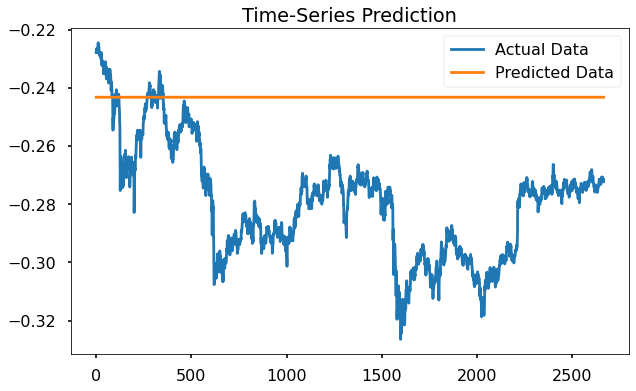

Epoch: 920, train loss: 0.00238, test loss: 0.00168


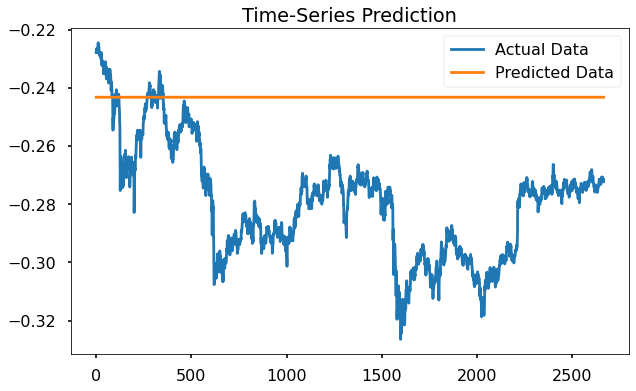

Epoch: 930, train loss: 0.00238, test loss: 0.00168


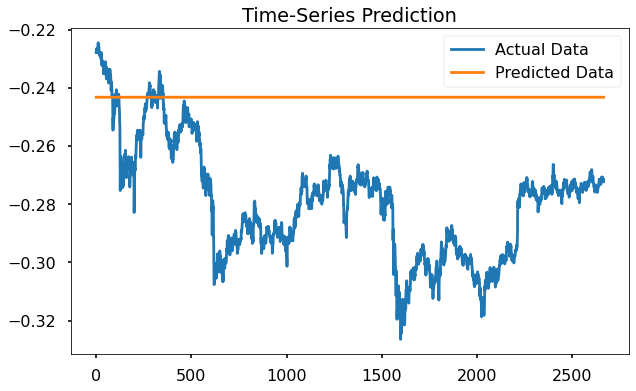

Epoch: 940, train loss: 0.00238, test loss: 0.00168


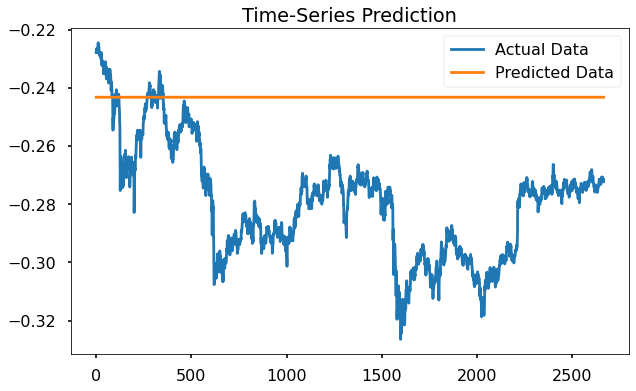

Epoch: 950, train loss: 0.00238, test loss: 0.00168


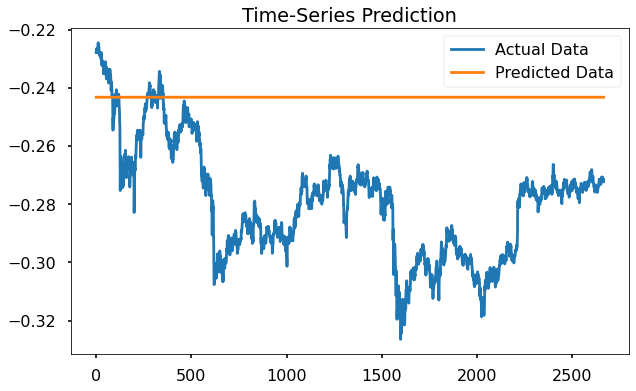

Epoch: 960, train loss: 0.00238, test loss: 0.00168


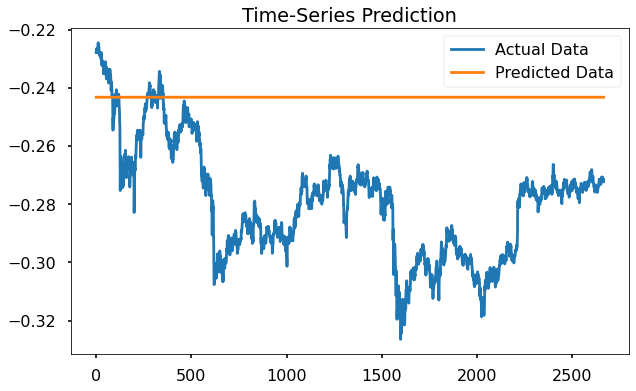

Epoch: 970, train loss: 0.00238, test loss: 0.00168


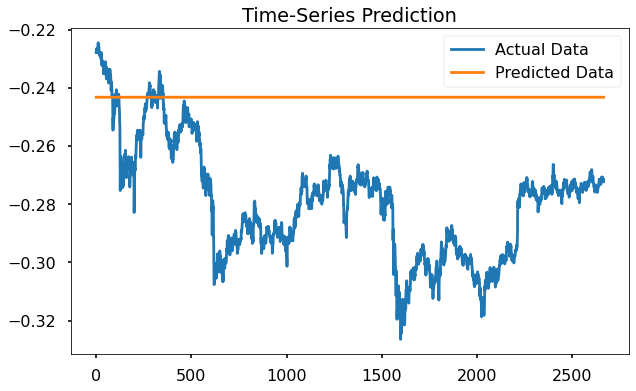

Epoch: 980, train loss: 0.00238, test loss: 0.00168


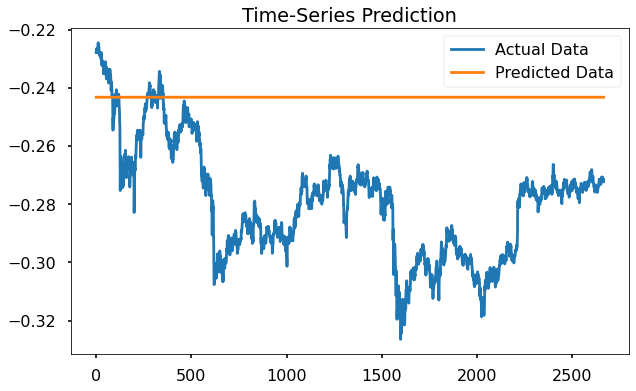

Epoch: 990, train loss: 0.00238, test loss: 0.00168


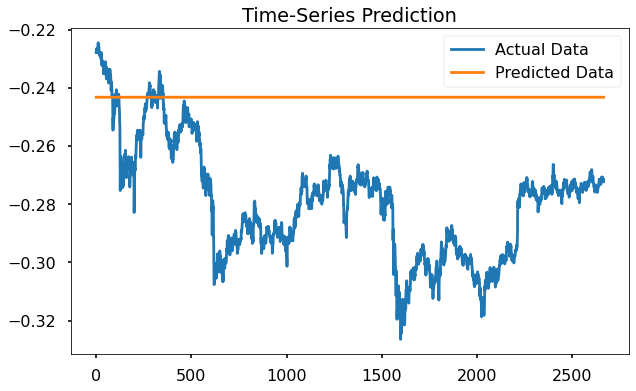

In [166]:
tscv = TimeSeriesSplit(n_splits=2) #TODO: revisar si tenemos que fijar el tamaño para test
training_history_by_split_1 = []
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = X_train[['Close']], X_test[['Close']]
    X_train = X_train.drop('Close', axis=1) 
    X_test = X_test.drop('Close', axis=1)

    #https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
    X_train_tensors = Variable(torch.Tensor(X_train
                                            .values))
    X_test_tensors = Variable(torch.Tensor(X_test
                                           .values))

    y_train_tensors = Variable(torch.Tensor(y_train.values))
    y_test_tensors = Variable(torch.Tensor(y_test.values))

    # reshaping to rows, timestamps, features
    X_train_tensors_final = torch.reshape(X_train_tensors,   
                                          (X_train_tensors.shape[0], 1, 
                                           X_train_tensors.shape[1]))
    X_test_tensors_final = torch.reshape(X_test_tensors,  
                                         (X_test_tensors.shape[0], 1, 
                                          X_test_tensors.shape[1])) 
    training_history = training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimizer=optimizer,
              loss_fn=criterion,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)
    
    training_history_by_split_1.append(training_history)

In [113]:
training_history_by_split_1

[[(LSTM(
     (lstm): LSTM(25, 13, batch_first=True, dropout=0.2)
     (fc_1): Linear(in_features=13, out_features=128, bias=True)
     (fc_2): Linear(in_features=128, out_features=1, bias=True)
     (relu): ReLU()
   ),
   0.3261774480342865,
   2.731239080429077),
  (LSTM(
     (lstm): LSTM(25, 13, batch_first=True, dropout=0.2)
     (fc_1): Linear(in_features=13, out_features=128, bias=True)
     (fc_2): Linear(in_features=128, out_features=1, bias=True)
     (relu): ReLU()
   ),
   2.9822189807891846,
   0.038378775119781494),
  (LSTM(
     (lstm): LSTM(25, 13, batch_first=True, dropout=0.2)
     (fc_1): Linear(in_features=13, out_features=128, bias=True)
     (fc_2): Linear(in_features=128, out_features=1, bias=True)
     (relu): ReLU()
   ),
   0.07039138674736023,
   0.2380823791027069),
  (LSTM(
     (lstm): LSTM(25, 13, batch_first=True, dropout=0.2)
     (fc_1): Linear(in_features=13, out_features=128, bias=True)
     (fc_2): Linear(in_features=128, out_features=1, bias=True)

## Evaluation

In [ ]:
def scaleDataFrame(df):
    features = ['Close_previous', 'Close', 'Volume_BTC', 'Volume_USD',
           'volume_adi', 'volume_cmf', 'volume_fi', 'volume_vpt', 'volume_vwap',
           'volatility_kcw', 'volatility_kchi', 'volatility_ui', 'trend_sma_slow',
           'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_b', 'trend_adx',
           'momentum_stoch_signal', 'others_dr']

    mapper = DataFrameMapper([(features, StandardScaler())])
    scaled_features = mapper.fit_transform(df.copy(), len(features))
    scaled_df = pd.DataFrame(scaled_features, index=df.index, columns=features)

    scaled_df['Target'] = df['Target'] 
    scaled_df['Year'] = df['Year']
    scaled_df['Month'] = df['Month']
    scaled_df['Week'] = df['Week']
    scaled_df['Weekday'] = df['Weekday']
    scaled_df['Day'] = df['Day']
    scaled_df['Hour'] = df['Hour']
    return scaled_df

In [88]:
ground_truth = y[['Close']]
ground_truth

Close
728034  18547.63
728035  18554.30
728036  18575.16
728037  18607.87
728038  18572.44
...          ...
910037  57664.76
910038  57633.76
910039  57631.89
910040  57614.63
910041  57633.91

[182008 rows x 1 columns]

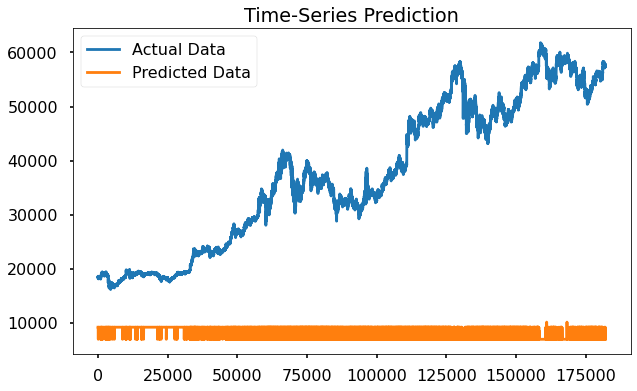

In [90]:
test = y.drop('Close', axis=1)
test_tensor = Variable(torch.Tensor(test
                                        .values))
# reshaping to rows, timestamps, features
test_tensor_final = torch.reshape(test_tensor,   
                                      (test_tensor.shape[0], 1, 
                                       test_tensor.shape[1]))
train_predict = lstm.forward(test_tensor_final) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = ground_truth.to_numpy()

true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
# plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 

In [41]:
test_tensor_final

tensor([[[ 2.6078e-01, -1.6367e-01, -1.4334e-01,  ...,  0.0000e+00,
           2.3000e+01,  1.1000e+01]],

        [[ 2.6156e-01, -2.7134e-01, -2.8145e-01,  ...,  0.0000e+00,
           2.3000e+01,  1.1000e+01]],

        [[ 2.6251e-01, -7.0446e-02, -2.3637e-02,  ...,  0.0000e+00,
           2.3000e+01,  1.1000e+01]],

        ...,

        [[ 3.3003e+00, -3.0866e-01, -3.0915e-01,  ...,  0.0000e+00,
           2.9000e+01,  2.0000e+01]],

        [[ 3.2976e+00, -1.0522e-01,  5.0083e-01,  ...,  0.0000e+00,
           2.9000e+01,  2.0000e+01]],

        [[        nan, -2.0952e-01,  8.5316e-02,  ...,  0.0000e+00,
           2.9000e+01,  2.0000e+01]]])

In [46]:
train_predict

tensor([[-0.1628],
        [-0.1628],
        [-0.1628],
        ...,
        [-0.1628],
        [-0.1628],
        [    nan]], grad_fn=<AddmmBackward0>)

In [ ]:
tscv = TimeSeriesSplit(n_splits=2) #TODO: revisar si tenemos que fijar el tamaño para test
training_history_by_split = []
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = X_train[['Close']], X_test[['Close']]
    

In [145]:
# Send the model to GPU if available
if torch.cuda.is_available():
    print("hey")

In [146]:
torch.zeros(1).cuda()

AssertionError: Torch not compiled with CUDA enabled